In [ ]:
#Mount and import packages, read dataset to csv
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/DAT490 Working Folder/Main model working folder/GSPCIndicators2.csv"
path2 = "/content/drive/My Drive/Colab Notebooks/TSPFundHist.csv"
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
gspc = pd.read_csv(path)
#cfund = pd.read_csv(path2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gspc = gspc.dropna()
gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent'],
      dtype='object')

In [ ]:
gspc['Date'] = pd.to_datetime(gspc['Date'])

In [ ]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,10DaysOutcome,10DaysPercent,20DaysOutcome,20DaysPercent,30DaysOutcome,30DaysPercent,45DaysOutcome,45DaysPercent,60DaysOutcome,60DaysPercent
0,1928-02-17,17.040001,17.040001,17.040001,17.040001,0.0,17.040001,17.440963,17.4995,17.213740,...,17.570000,0.031103,18.360001,0.077465,18.91,0.109742,19.250000,0.129695,20.389999,0.196596
1,1928-02-20,16.950001,16.950001,16.950001,16.950001,0.0,16.950001,17.394205,17.4730,17.099954,...,17.670000,0.042478,18.459999,0.089085,19.02,0.122124,19.330000,0.140413,20.049999,0.182891
2,1928-02-21,17.110001,17.110001,17.110001,17.110001,0.0,17.110001,17.367138,17.4465,17.050103,...,17.580000,0.027469,18.650000,0.090006,18.99,0.109877,19.469999,0.137931,20.120001,0.175921
3,1928-02-23,17.129999,17.129999,17.129999,17.129999,0.0,17.129999,17.344553,17.4175,17.017607,...,17.639999,0.029772,18.600000,0.085814,19.23,0.122592,19.680000,0.148862,19.920000,0.162872
4,1928-02-24,17.180000,17.180000,17.180000,17.180000,0.0,17.180000,17.328881,17.4005,16.990697,...,17.930000,0.043655,18.780001,0.093132,19.27,0.121653,19.750000,0.149593,19.629999,0.142608


We want to engineer a target variable with enough instances to be exploitable, but enough separation from the mean which has shown very little predictability. To find a threshold, let's look at the distribution.

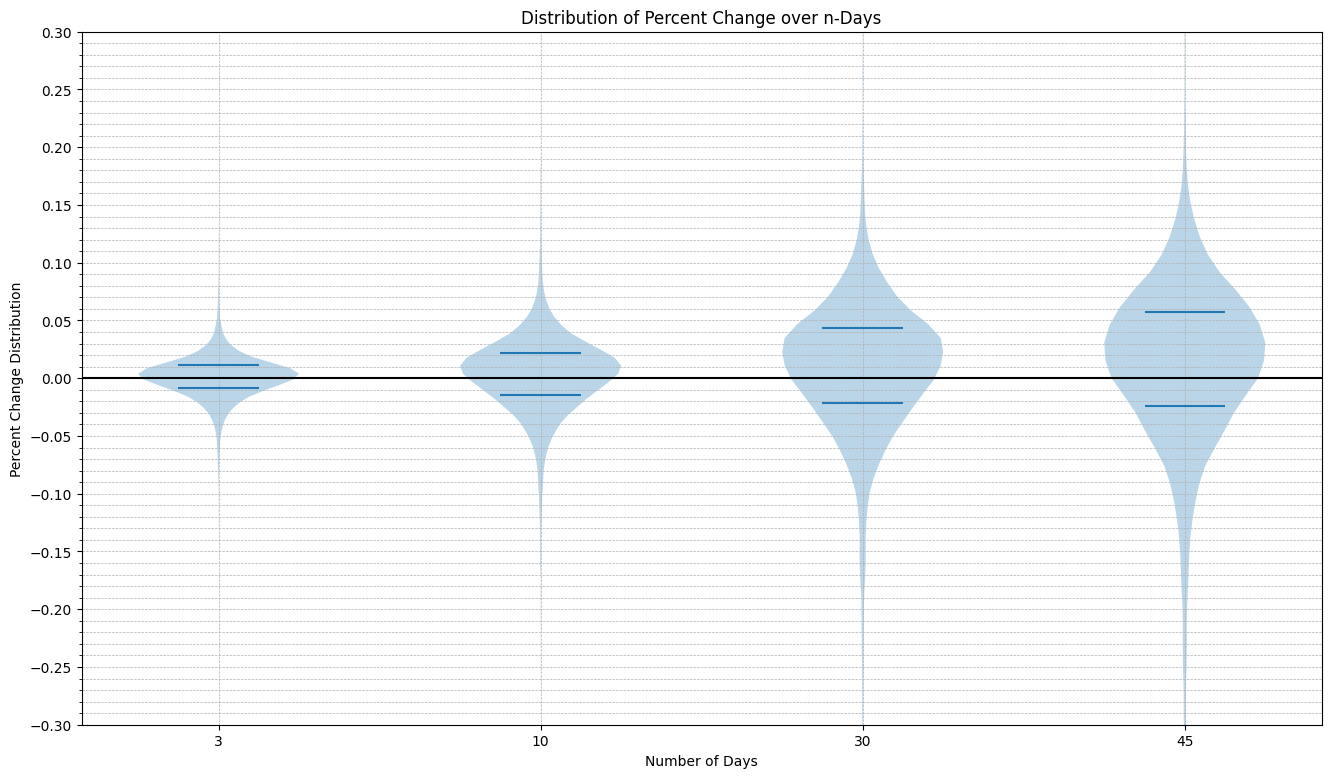

In [ ]:
percents = pd.DataFrame(gspc[['3DaysPercent','10DaysPercent','30DaysPercent','45DaysPercent']].astype(float))
fig, ax = plt.subplots(figsize=(16,9))
ax.violinplot(percents,showextrema=False,quantiles=[[0.75,0.25],[0.75,0.25],[0.75,0.25],[0.75,0.25]])
ax.set_title('Distribution of Percent Change over n-Days')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Percent Change Distribution')
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['3','10','30','45'])
ax.set_ylim(bottom=-0.3,top=0.3)
ax.set_yticks(np.arange(-0.3,0.31,0.05),minor=False)
ax.set_yticks(np.arange(-0.3,0.31,0.01),minor=True)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=0,color='k',linestyle='-')
plt.show()

Considering that n=3 & n=10 did not have much separation off of the mean which has shown to be unreliable in predictive modeling, we expect the n=30 time frame to be the most beneficial. +/- 5% seems to be the bounds of the first and third quartiles, so we will utilize this threshold to test.

In [ ]:
gspc['nDaysDown'] = gspc['30DaysPercent']<-0.035
gspc['nDaysUp'] = gspc['30DaysPercent']>0.035

In [ ]:
gspc['nDaysDown'].value_counts()

,count
nDaysDown,
False,19868
True,4445


In [ ]:
gspc['nDaysPos'] = gspc['30DaysPercent']>0
gspc['nDaysNeg'] = gspc['30DaysPercent']<0
gspc['nDaysPos'].value_counts()

,count
nDaysPos,
True,14806
False,9507


In [ ]:
gspc['nDaysUp'].value_counts()

,count
nDaysUp,
False,16535
True,7778


In [ ]:
gspc['nDaysDown'] = gspc['nDaysDown'].astype(int)
gspc['nDaysUp'] = gspc['nDaysUp'].astype(int)

Now that the dataset has been prepared with an engineered target variable, we create some signal features using the previously extracted financial indicators and domain knowledge from our reading of financial literature.

In [ ]:
#Encoding MACD Buy/Sell Signals Algorithmically
macd = 'neg'
macd_buy = []
macd_sell = []
counter = 1
for i in range(len(gspc)):
  if gspc['macd'].iloc[i] >= 0 and macd == 'neg':
    macd_buy.append(1)
    macd_sell.append(0)
    macd = 'pos'
  elif gspc['macd'].iloc[i] < 0 and macd == 'pos':
    macd_sell.append(1)
    macd_buy.append(0)
    macd = 'neg'
  else:
    macd_sell.append(0)
    macd_buy.append(0)
  i += 1
macd_buy = pd.Series(macd_buy)
macd_sell = pd.Series(macd_sell)
gspc['macd_buy'] = macd_buy
gspc['macd_sell'] = macd_sell



In [ ]:
gspc['macd_buy'].value_counts()

,count
macd_buy,
0,23831
1,482


In [ ]:
#Encoding EMA Buy/Sell Signals Algorithmically
EMA_Indication = 'over'
ema_buy = []
ema_sell = []
for i in range(len(gspc)):
  if (gspc['EMA'].iloc[i] > gspc['GSPC.Close'].iloc[i]) and EMA_Indication == 'below':
    EMA_Indication = 'over'
    ema_sell.append(1)
    ema_buy.append(0)
  elif (gspc['EMA'].iloc[i] < gspc['GSPC.Close'].iloc[i]) and EMA_Indication == 'over':
    EMA_Indication = 'below'
    ema_buy.append(1)
    ema_sell.append(0)
  else:
    ema_buy.append(0)
    ema_sell.append(0)
  i += 1
ema_buy = pd.Series(ema_buy)
ema_sell = pd.Series(ema_sell)
gspc['ema_buy'] = ema_buy
gspc['ema_sell'] = ema_sell

In [ ]:
gspc['ema_buy'].value_counts()

,count
ema_buy,
0,22875
1,1438


In [ ]:
#Encoding RSI/ROC Signals Algorithmically
#If over 70 and still has positive rate of change vs if rate of change has decreased. Same for 30 RSI.
risingROC70RSI = []
fallingROC70RSI = []
risingROC30RSI = []
fallingROC30RSI = []
for i in range(len(gspc)):
  if (gspc['rsi'].iloc[i] > 70) and (gspc['2dayROC'].iloc[i] > 0):
    risingROC70RSI.append(1)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  elif (gspc['rsi'].iloc[i] > 70) and (gspc['2dayROC'].iloc[i] <= 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(1)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  elif (gspc['rsi'].iloc[i] < 30) and (gspc['2dayROC'].iloc[i] > 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(1)
    fallingROC30RSI.append(0)
  elif (gspc['rsi'].iloc[i] < 30) and (gspc['2dayROC'].iloc[i] <= 0):
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(1)
  else:
    risingROC70RSI.append(0)
    fallingROC70RSI.append(0)
    risingROC30RSI.append(0)
    fallingROC30RSI.append(0)
  i += 1
risingROC70RSI = pd.Series(risingROC70RSI)
fallingROC70RSI = pd.Series(fallingROC70RSI)
risingROC30RSI = pd.Series(risingROC30RSI)
fallingROC30RSI = pd.Series(fallingROC30RSI)
gspc['risingROC70RSI'] = risingROC70RSI
gspc['fallingROC70RSI'] = fallingROC70RSI
gspc['risingROC30RSI'] = risingROC30RSI
gspc['fallingROC30RSI'] = fallingROC30RSI

In [ ]:
gspc['risingROC70RSI'].value_counts()

,count
risingROC70RSI,
0,22113
1,2200


In [ ]:
gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI'],
      dtype='object')

In [ ]:
gspc = gspc.dropna()

In [ ]:
gspc.describe()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,nDaysDown,nDaysUp,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI
count,24313,24313.000000,24313.000000,24313.000000,24313.000000,2.431300e+04,24313.000000,24313.000000,24313.000000,24313.000000,...,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000,24313.000000
mean,1976-08-10 18:19:30.040718976,634.733091,658.302881,650.469465,654.638153,9.177458e+08,654.638153,652.325730,652.314341,631.803220,...,0.182824,0.319911,0.019825,0.019784,0.059145,0.059104,0.090487,0.014642,0.002468,0.034262
min,1928-02-17 00:00:00,0.000000,4.400000,4.400000,4.400000,0.000000e+00,4.400000,4.650827,4.632000,4.010519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1952-06-19 00:00:00,9.710000,24.780001,24.780001,24.780001,1.570000e+06,24.780001,24.789277,24.811000,24.171804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1976-09-14 00:00:00,43.509998,103.500000,101.809998,102.599998,2.077000e+07,102.599998,102.618341,102.538500,99.829183,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2000-10-02 00:00:00,1047.489990,1053.979980,1039.880005,1047.699951,1.027500e+09,1047.699951,1046.544884,1047.187006,998.979775,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-11-29 00:00:00,6014.109863,6044.169922,6003.979980,6032.379883,1.145623e+10,6032.379883,5935.580748,5929.915991,5750.496920,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,1085.637273,1080.524194,1068.553623,1074.932990,1.626016e+09,1074.932990,1069.565552,1069.621574,1036.394536,...,0.386530,0.466451,0.139401,0.139259,0.235901,0.235824,0.286883,0.120119,0.049617,0.181904


Now to prepare the data we will actually use in the model. For this, we will limit the features to solely our engineered features, with the exception of 2 day Price Rate of Change and 2 day Momentum.

In [ ]:
X = gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = gspc['nDaysDown']
y2 = gspc['nDaysUp']

To ensure the model is deployable and readable, we are not utilizing the StandardScaler. The features are nearly all binary, and all within +/1 1, so they are pretty much already scaled.

In [ ]:
X = pd.DataFrame(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=0)

In [ ]:
X_posneg = gspc[['nDaysPos','nDaysNeg']]
y_posneg = gspc['nDaysUp']
X_train_posneg, X_test_posneg, y_train_posneg, y_test_posneg = train_test_split(X_posneg, y_posneg, test_size=0.2, random_state=0)

In [ ]:
X.head()

,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,2dayROC,macd_buy,macd_sell,2dayMomentum
0,0,0,0,0,0,0,-0.020907,0,0,-0.359999
1,0,0,0,0,0,0,-0.023325,0,0,-0.400000
2,0,0,0,0,0,0,0.004100,0,0,0.070000
3,0,0,0,0,0,0,0.010563,0,0,0.179998
4,0,0,0,0,0,0,0.004083,0,0,0.070000


Training the model. We are utilizing XGBoost for this test.

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_pred2[i] == 1:
    y_pred[i] = 0
    y_pred2[i] = 0
  i += 1

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))

[[3942   61]
 [ 835   25]]
0.815751593666461
[[3711  292]
 [ 796   64]]
0.7762697923092741
[[3942   61]
 [ 835   25]]
0.815751593666461
[[3711  292]
 [ 796   64]]
0.7762697923092741


In [ ]:
y_test.value_counts()

,count
nDaysDown,
0,4003
1,860


In [ ]:
y_test_posneg.value_counts()

,count
nDaysUp,
0,3324
1,1539


In [ ]:
updays = X_test_posneg['nDaysPos']
downdays = X_test_posneg['nDaysNeg']
downpred = (downdays*y_pred).astype(int)
uppred = (updays*y_pred2).astype(int)

cm = confusion_matrix(downdays, y_pred)
print(cm)
print(accuracy_score(downdays, y_pred))

[[2918   41]
 [1859   45]]
0.6092946740695044


In [ ]:
downdays.value_counts()

,count
nDaysNeg,
False,2959
True,1904


In [ ]:
y_test.value_counts()

,count
nDaysDown,
0,4003
1,860


0.87 accuracy is great, but notice the very few True Positives for any of the confusion matrices. Those True Positives are where we will buy or sell index funds in simulation, so we want to ensure we are getting as many as we can. Let's look at the performance on the training set to see if the accuracy is similar to the test set as a litmus test for overfitting.

In [ ]:
y_train_test = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_test)
print(cm)
accuracy_score(y_train, y_train_test)

[[15812    53]
 [ 3299   286]]


0.8276606683804627

Notice that accuracy on the training set was within a single percent of the test set. It seems the model is not overfitting the data.

Now let us look at Decision Tree Classifier to see if it is any better. In testing, this overfitted the data wildly. As such max_depth was adjusted to simplify the model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,max_depth=5)
classifier2 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,max_depth=5)
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))
for i in range(len(y_pred)):
  if y_pred[i] == 1 and y_pred2[i] == 1:
    y_pred[i] = 0
    y_pred2[i] = 0
  i += 1
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred2)
print(cm)
print(accuracy_score(y_test, y_pred2))

[[3997    6]
 [ 858    2]]
0.8223318938926588
[[3968   35]
 [ 856    4]]
0.8167797655768044
[[3997    6]
 [ 858    2]]
0.8223318938926588
[[3968   35]
 [ 856    4]]
0.8167797655768044


In [ ]:
y_train_test = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_test)
print(cm)
accuracy_score(y_train, y_train_test)

[[15861     4]
 [ 3553    32]]


0.817120822622108

The accuracy metric is much the same as it was for XGBoost, but True Positive performance is, comparatively, absolutely awful. Let's bring back the XGBoost model and run a simulation or two to see if there is positive expected value from the machine learned trading strategy.

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X_train, y_train)
classifier2.fit(X_train2, y_train2)
y_pred = classifier.predict(X_test)
y_pred2 = classifier2.predict(X_test2)

In [ ]:
gspc['sell'] = classifier.predict(X)
gspc['buy'] = classifier2.predict(X)

In [ ]:
gspc['sell'].value_counts()

,count
sell,
0,23888
1,425


***Simulation Setup***

*Method* - We will begin in 1927 with exactly one stock worth of value, which equates to $17.04. Each day, the prediction columns which have been encoded as 'buy' and 'sell' will be observed. If 'buy' and 'sell' have the same value, the stock or cash will be held, as the model is either indicating it is neither a buy or sell, or the model is indicating it is both a buy or a sell, in which case it must be wrong on one of those accounts and we should make no trading action on the insight.

If there is cash in hand and the signal is to buy, then the cash on hand is appended to a rolling record of the cash value of the total account (stock plus cash), stock is updated to the cash in hand divided by the stock price, the stock number is appended to the stock record, and the algorithm moves to the next day. A similar process is done but for selling if the cash in hand is 0 and the indication is to sell. If no indication happens, the stock and cash records are appended with the current day's value, and the algorithm moves on.

So we start with 1 stock, and we want to see as many ending stocks as we can to show that the swing trading was effective. **This particular simulation is done with no frequency limits other than max of 1 per day as that is the temporal resolution of the dataset.**

In [ ]:
cash = 17.04
stock = 0
cashinhand = 1
cash_record = []
stock_record = []
counter = 1
counter_record = []
for i in range(len(gspc)):
  if gspc['buy'].iloc[i] ==1 and gspc['sell'].iloc[i] == 0 and cashinhand == 1:
    cash_record.append(cash)
    stock = cash/gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    counter += 1
    counter_record.append(1)
  elif gspc['sell'].iloc[i] == 1 and gspc['buy'].iloc[i] ==0 and cashinhand == 0:
    stock_record.append(stock)
    cash = stock*gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    counter += 1
    counter_record.append(1)
  else:
    counter_record.append(0)
    if stock == 0:
      stock_record.append(cash/gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*gspc['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 1121.3125026750486 398


In [ ]:
cash_record[-5:]

[np.float64(6693495.399793524),
 np.float64(6713712.970335069),
 np.float64(6752128.874289589),
 np.float64(6726462.424684046),
 np.float64(6764182.983693346)]

The ending account comes in at over 376 stocks worth of value! Let's plot the growth using the cash record we kept alongside the S&P 500 index price record. We will use a logarithmic scale to allow interrogation of fluctuation.

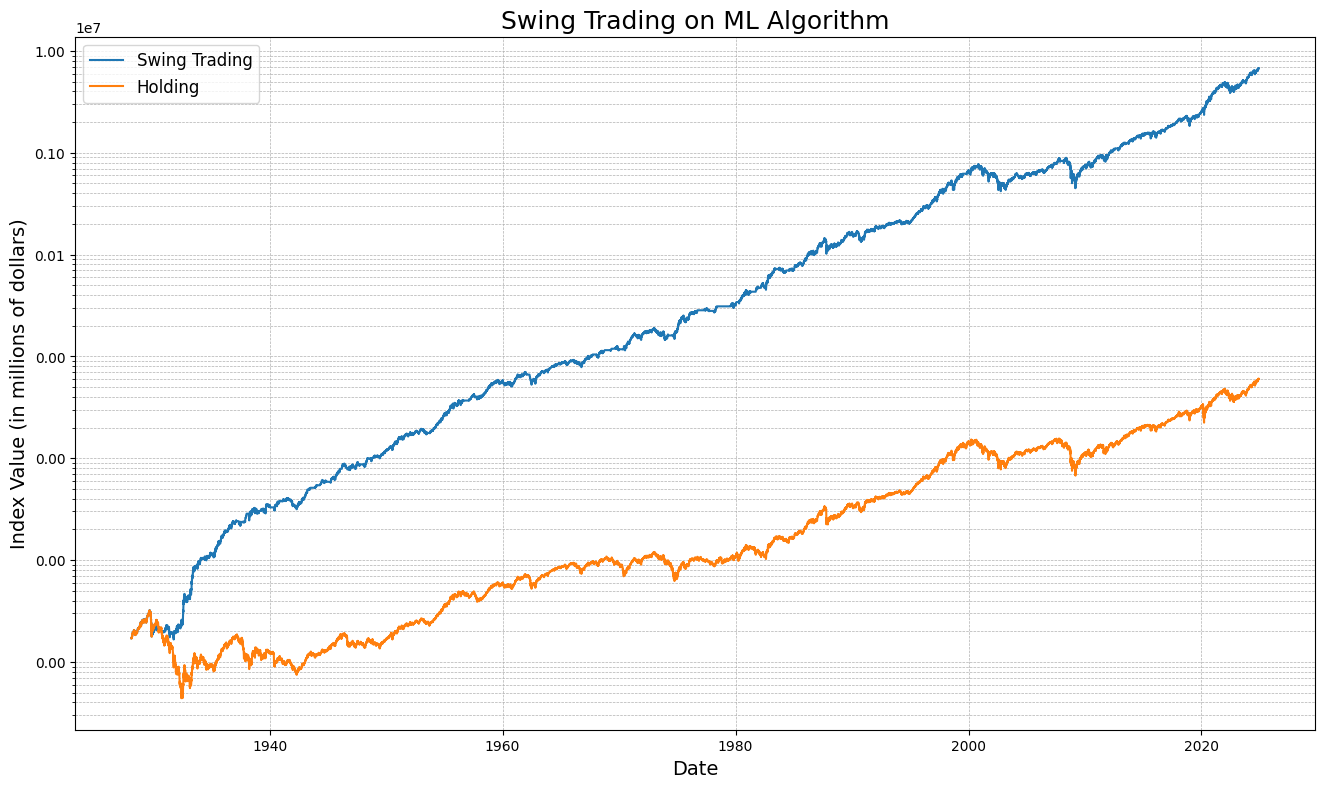

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in millions of dollars)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

And then on a linear scale. ***for fun***

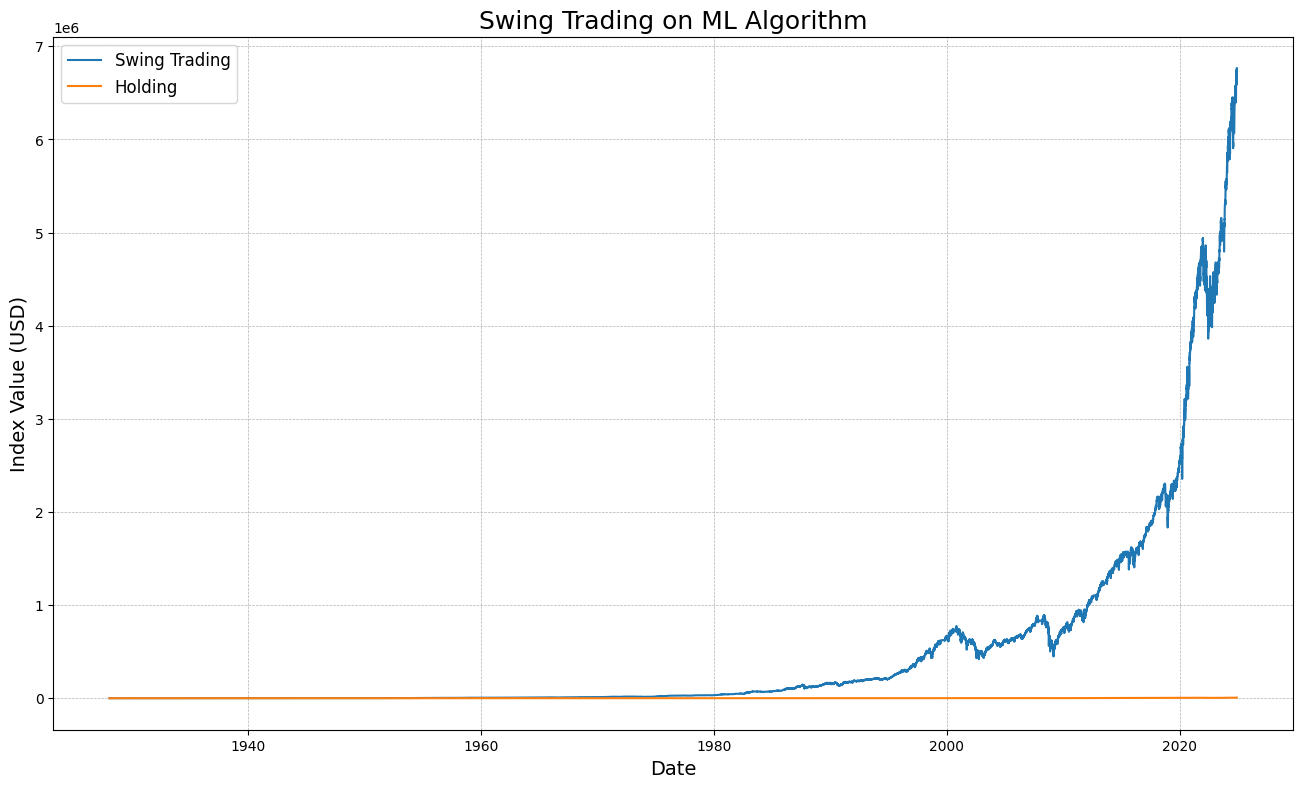

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In the next code block, I simulate trade action where only two trades per calendar month are permitted to mimic my own retirement fund, which follows the S&P 500 and has the same restriction on fund transfers. A counter is maintained which is reset each time the calendar month variable changes, which is assessed daily. If the trade counter hits 2, no more trades are facilitated during that month.

In [ ]:
import datetime
cash = 0
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = gspc['Date'].iloc[0].month
for i in range(len(gspc)):
  month_of_record = gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  if gspc['buy'].iloc[i] ==1 and gspc['sell'].iloc[i] ==0 and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif gspc['sell'].iloc[i] == 1 and gspc['buy'].iloc[i] ==0 and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*gspc['GSPC.Close'].iloc[i])
    else:
      cash_record.append(cash + stock*gspc['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/gspc['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 763.9432325014837 345


In [ ]:
cash_record[-5:]

[np.float64(4560236.776325263),
 np.float64(4574010.881363767),
 np.float64(4600183.397746551),
 np.float64(4582697.005298667),
 np.float64(4608395.787495942)]

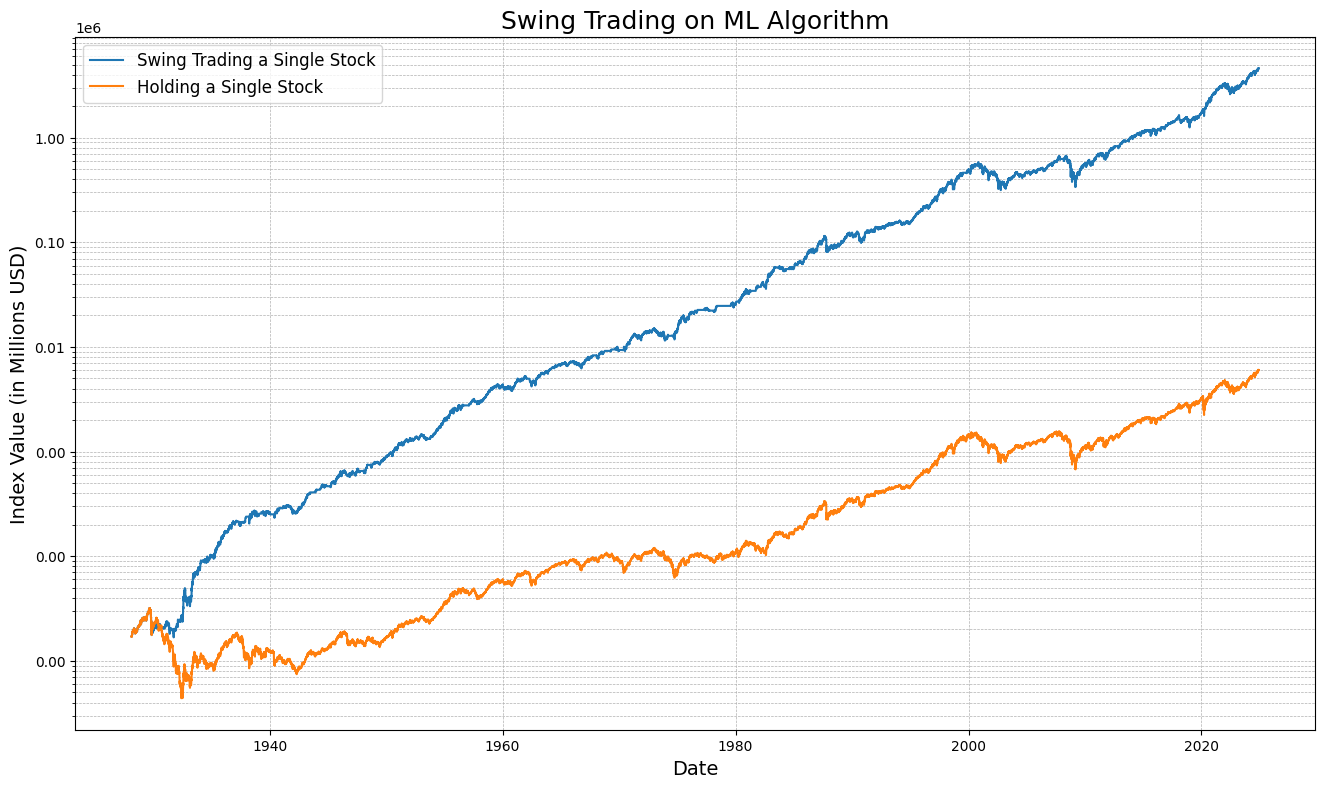

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading a Single Stock')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding a Single Stock')
ax.set_title('Swing Trading on ML Algorithm', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

Interestingly, the performance actually increased, but not by a notable margin. This seems to show that the frequency of signals are not high enough to impede trade actions on limited accounts.

Next, I will observe the period surrounding the Great Recession and 2008 Housing Crisis to see how the model handles extreme market reactions.

In [ ]:
recessiondf = gspc[20000:21000]
recessiondf.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
20000,2007-10-12,1555.410034,1563.030029,1554.089966,1561.800049,2.788690e+09,1561.800049,1535.292710,1535.927502,1494.135546,...,0,0,0,0,0,0,0,0,0,0
20001,2007-10-15,1562.250000,1564.739990,1540.810059,1548.709961,3.139290e+09,1548.709961,1536.570544,1539.530499,1507.521818,...,0,0,0,0,0,0,0,0,0,0
20002,2007-10-16,1547.810059,1547.810059,1536.290039,1538.530029,3.234560e+09,1538.530029,1536.757161,1540.467999,1509.756047,...,0,0,0,0,0,0,0,0,0,0
20003,2007-10-17,1544.439941,1550.660034,1526.010010,1541.239990,3.638070e+09,1541.239990,1537.184097,1541.078497,1510.818178,...,0,0,0,0,0,0,0,0,0,0
20004,2007-10-18,1539.290039,1542.790039,1531.760010,1540.079956,3.203210e+09,1540.079956,1537.459893,1542.144995,1513.655974,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = recessiondf['Date'].iloc[0].month
for i in range(len(recessiondf)):
  month_of_record = recessiondf['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
  if recessiondf['buy'].iloc[i] ==1 and recessiondf['sell'].iloc[i] ==0 and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/recessiondf['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif recessiondf['sell'].iloc[i] == 1 and recessiondf['buy'].iloc[i] ==0 and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*recessiondf['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/recessiondf['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*recessiondf['GSPC.Close'].iloc[i])
  i += 1
print(cash, stock, counter)

0 1.310713113870489 11


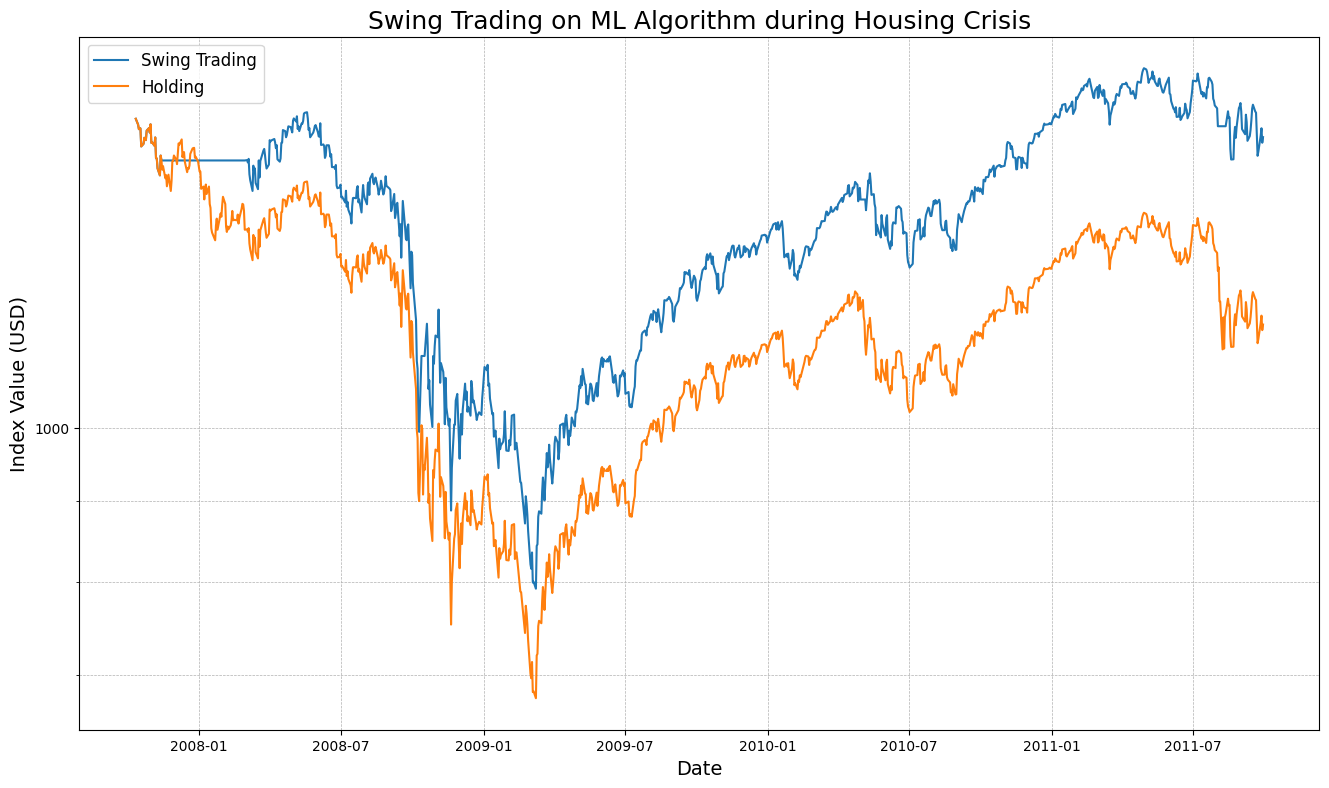

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(recessiondf['Date'],cash_record, label='Swing Trading')
plt.plot(recessiondf['Date'],recessiondf['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm during Housing Crisis', fontsize=18)

ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

This is a pretty nice success! Not only did we not lose money worse than the market did, but we exceeded the market by 1.7x.

For fun, let's invest in 10% of a stock in the S&P 500 every month we are in it and rerun the simulation from 1927.

In [ ]:
import datetime
cash = 17.04
stock = 0
cashinhand = 1
cash_record = []
stock_record = []
counter = 1
month_trades = 0
curr_month = gspc['Date'].iloc[0].month
for i in range(len(gspc)):
  month_of_record = gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    cash += gspc['GSPC.Close'].iloc[i]/10
  if (gspc['buy'].iloc[i] ==1) and (gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter += 1
  elif (gspc['sell'].iloc[i] == 1) and (gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter += 1
  else:
    if stock == 0:
      stock_record.append(cash/gspc['GSPC.Close'].iloc[i])
      cash_record.append(cash)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*gspc['GSPC.Close'].iloc[i])
    else:
      cash_record.append(cash + stock*gspc['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/gspc['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Cash Value: %10.2f" % stock_record[len(stock_record)-1].astype(int))

Cash Value:   12659016
Cash Value:    2098.00


That is 7.2 Million dollars.

Looking into the data, the Great Recession hit HARD.

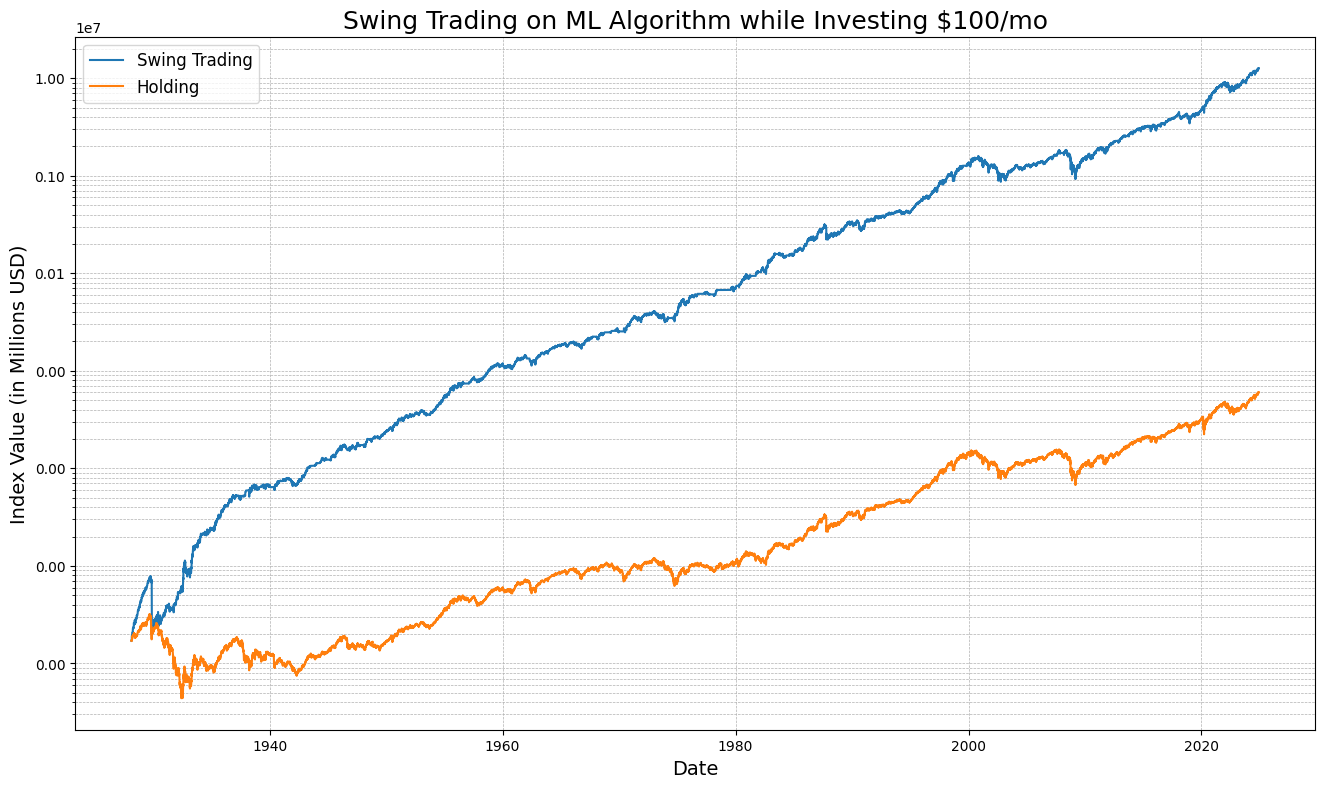

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'],cash_record, label='Swing Trading')
plt.plot(gspc['Date'],gspc['GSPC.Close'],label='Holding')
ax.set_title('Swing Trading on ML Algorithm while Investing $100/mo', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

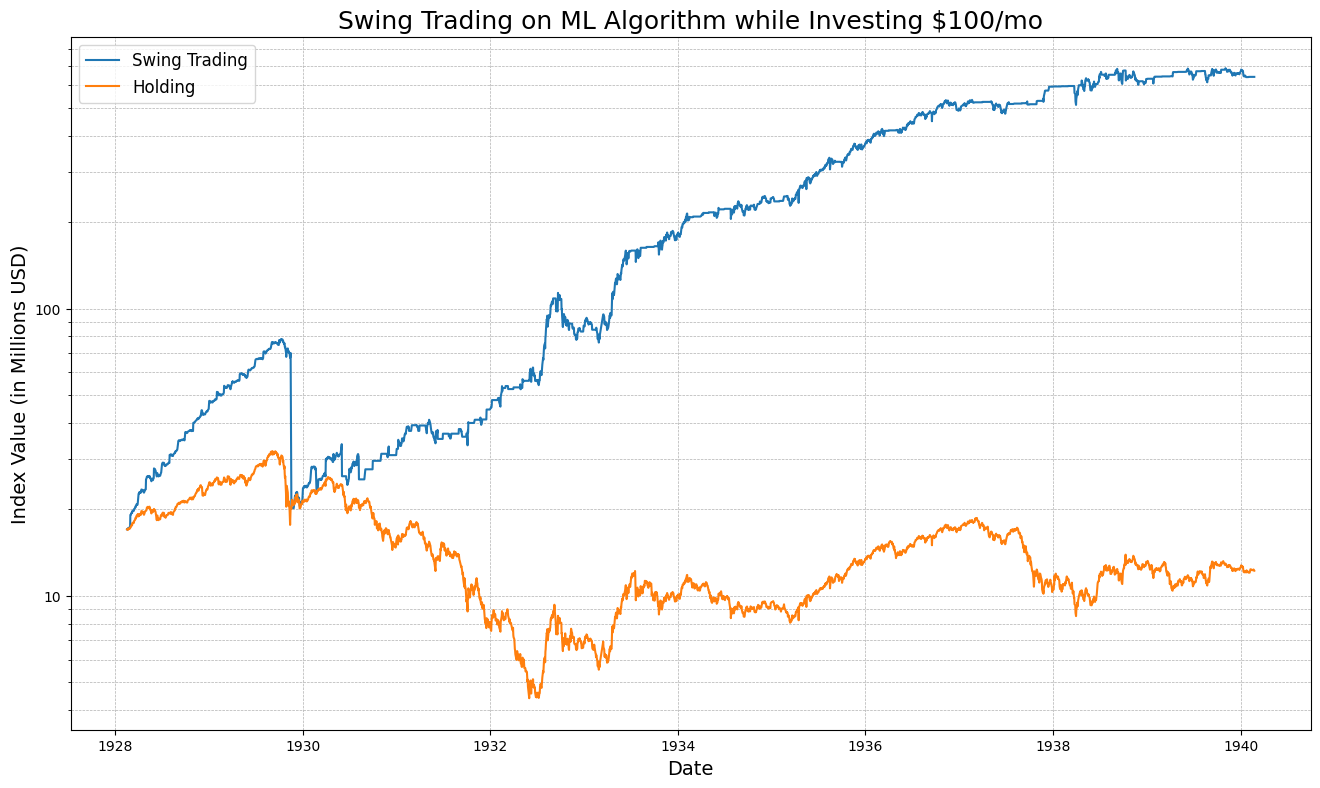

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(gspc['Date'][0:3000],cash_record[0:3000], label='Swing Trading')
plt.plot(gspc['Date'][0:3000],gspc['GSPC.Close'][0:3000],label='Holding')
ax.set_title('Swing Trading on ML Algorithm while Investing $100/mo', fontsize=18)
ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (in Millions USD)', fontsize=14)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

Now for a realistic test. Let's set a start date of when I began contributing to my funds. And let's put in 400 a month to simulate a ~15 percent income contribution to the fund. How would it perform? Will it outperform holding?

In [ ]:
realistic_history = gspc[22265:]
realistic_history.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
22265,2016-10-11,2161.35,2161.56,2128.84,2136.73,3393060000.00,2136.73,2156.92,2153.96,2128.01,...,0,0,0,1,0,0,0,0,0,0
22266,2016-10-12,2137.67,2145.36,2132.77,2139.18,2959510000.00,2139.18,2155.23,2154.63,2131.04,...,0,0,0,0,0,0,0,0,0,0
22267,2016-10-13,2130.26,2138.19,2114.72,2132.55,3538030000.00,2132.55,2153.07,2153.89,2128.58,...,0,0,0,0,0,0,0,0,0,0
22268,2016-10-14,2139.68,2149.19,2132.98,2132.98,3187910000.00,2132.98,2151.15,2153.58,2127.42,...,0,0,0,0,0,0,0,0,0,0
22269,2016-10-17,2132.95,2135.61,2124.43,2126.50,2832440000.00,2126.50,2148.81,2152.95,2124.89,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
cross_check_rh = realistic_history.copy()
cross_check_rh.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
22265,2016-10-11,2161.35,2161.56,2128.84,2136.73,3393060000.00,2136.73,2156.92,2153.96,2128.01,...,0,0,0,1,0,0,0,0,0,0
22266,2016-10-12,2137.67,2145.36,2132.77,2139.18,2959510000.00,2139.18,2155.23,2154.63,2131.04,...,0,0,0,0,0,0,0,0,0,0
22267,2016-10-13,2130.26,2138.19,2114.72,2132.55,3538030000.00,2132.55,2153.07,2153.89,2128.58,...,0,0,0,0,0,0,0,0,0,0
22268,2016-10-14,2139.68,2149.19,2132.98,2132.98,3187910000.00,2132.98,2151.15,2153.58,2127.42,...,0,0,0,0,0,0,0,0,0,0
22269,2016-10-17,2132.95,2135.61,2124.43,2126.50,2832440000.00,2126.50,2148.81,2152.95,2124.89,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
counter = []
month_trades = 0
curr_month = realistic_history['Date'].iloc[0].month
for i in range(len(realistic_history)):
  month_of_record = realistic_history['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/realistic_history['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (realistic_history['buy'].iloc[i] ==1) and (realistic_history['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/realistic_history['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    counter.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
  elif (realistic_history['sell'].iloc[i] == 1) and (realistic_history['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*realistic_history['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    counter.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
  else:
    if stock == 0:
      stock_record.append(cash/realistic_history['GSPC.Close'].iloc[i])
      cash_record.append(cash)
      counter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*realistic_history['GSPC.Close'].iloc[i])
      counter.append(0)
    else:
      cash_record.append(cash + stock*realistic_history['GSPC.Close'].iloc[i])
      stock_record.append(stock + cash/realistic_history['GSPC.Close'].iloc[i])
      counter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      88895
Stock Value:      14.74
40936.729999999996


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = cross_check_rh['Date'].iloc[0].month
for i in range(len(cross_check_rh)):
  month_of_record = cross_check_rh['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/cross_check_rh['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*cross_check_rh['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/cross_check_rh['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      75744
Stock Value:      12.56
40936.729999999996


In [ ]:
88392/75744

1.1669835234474017

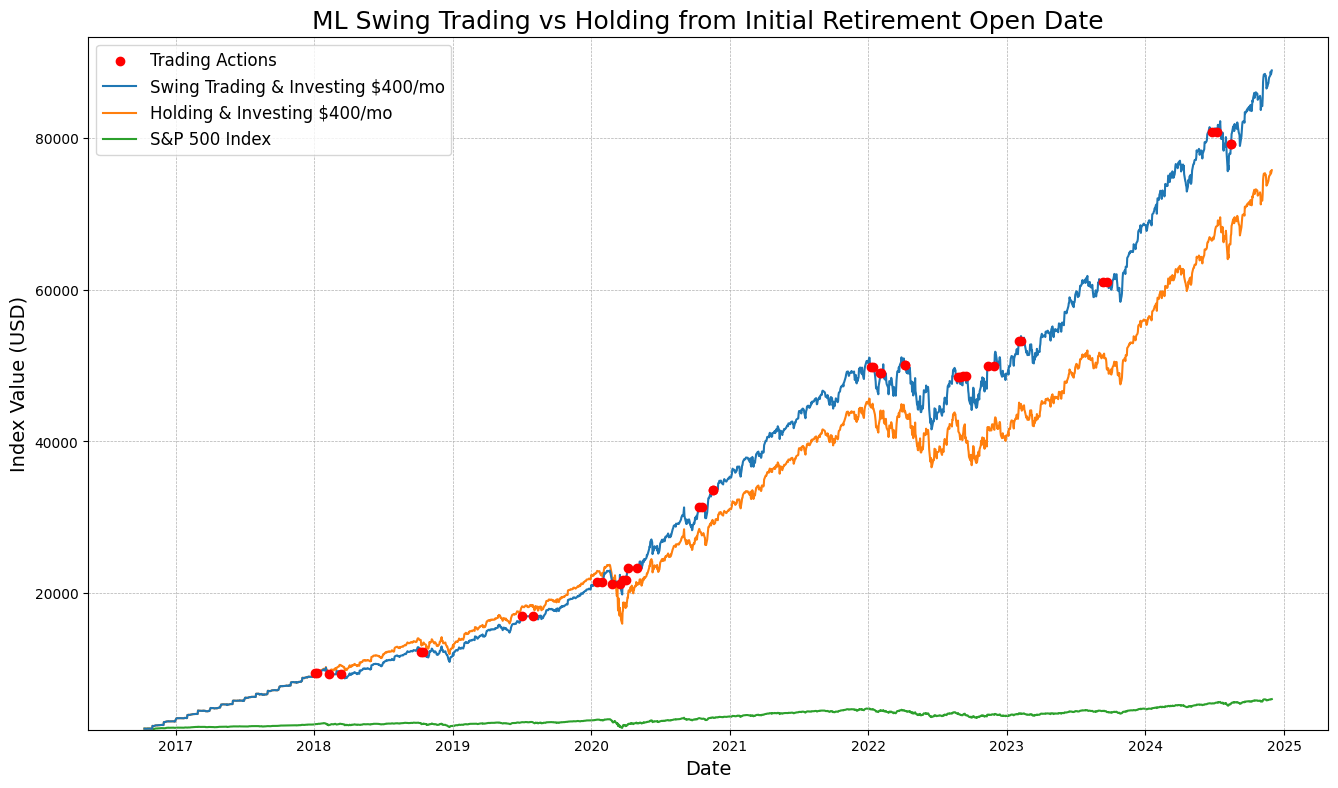

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(realistic_history['Date'],counter,color='r',label='Trading Actions',zorder=4)
plt.plot(realistic_history['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(cross_check_rh['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(realistic_history['Date'],realistic_history['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from Initial Retirement Open Date', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

So we come to the result that swing trading with this algorithm would have over doubled the money I have put into my retirement account.

In [ ]:
fortyYear_history = gspc[-10400:]
fortyYear_history.head()
cross_check_fh = fortyYear_history.copy()
cross_check_fh

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
13913,1983-08-26,160.85,162.16,160.25,162.14,61650000.00,162.14,163.06,162.32,159.40,...,0,0,0,0,0,0,0,0,0,0
13914,1983-08-29,162.14,162.32,160.97,162.25,53030000.00,162.25,162.98,162.33,159.42,...,0,0,0,0,0,0,0,0,0,0
13915,1983-08-30,162.25,163.13,162.11,162.58,62370000.00,162.58,162.95,162.36,159.45,...,1,0,0,0,0,0,0,0,0,0
13916,1983-08-31,162.55,164.40,162.32,164.40,80800000.00,164.40,163.08,162.41,159.40,...,0,0,1,0,0,0,0,0,0,0
13917,1983-09-01,164.40,164.66,163.95,164.23,76120000.00,164.23,163.19,162.55,159.48,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24308,2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000.00,5969.34,5898.24,5886.69,5696.29,...,0,0,0,0,0,0,0,0,0,0
24309,2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000.00,5987.37,5906.73,5894.88,5701.97,...,0,0,0,0,0,0,0,0,0,0
24310,2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000.00,6021.63,5917.67,5904.32,5706.07,...,0,0,0,0,0,0,0,0,0,0
24311,2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000.00,5998.74,5925.39,5913.57,5715.83,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = fortyYear_history['Date'].iloc[0].month
for i in range(len(fortyYear_history)):
  month_of_record = fortyYear_history['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/fortyYear_history['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (fortyYear_history['buy'].iloc[i] ==1) and (fortyYear_history['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/fortyYear_history['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*fortyYear_history['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (fortyYear_history['sell'].iloc[i] == 1) and (fortyYear_history['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*fortyYear_history['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*fortyYear_history['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*fortyYear_history['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:    3614654
Stock Value:     599.21
200136.72999999998


In [ ]:
import datetime
cash = 0
moneyspent = 2136.73
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = cross_check_fh['Date'].iloc[0].month
for i in range(len(cross_check_fh)):
  month_of_record = cross_check_fh['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/cross_check_fh['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*cross_check_fh['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/cross_check_fh['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:    1817275
Stock Value:     301.25
200136.72999999998


In [ ]:
5016529/1817275


2.7604677332819745

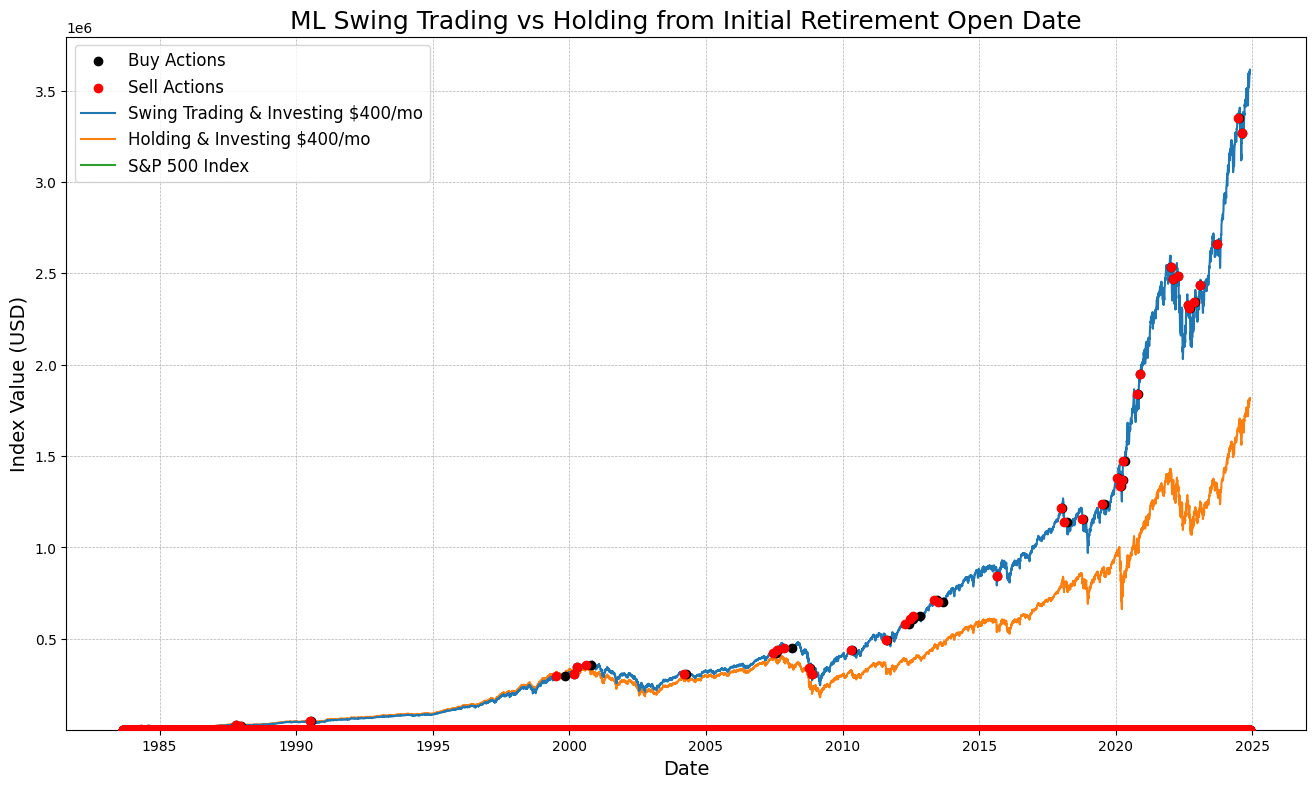

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(fortyYear_history['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(fortyYear_history['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(fortyYear_history['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(cross_check_fh['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(fortyYear_history['Date'],fortyYear_history['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from Initial Retirement Open Date', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
gspc['nDaysDown'].value_counts()

,count
nDaysDown,
0,19868
1,4445


In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg2 = LinearRegression()
X = gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = gspc['30DaysPercent']*100
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg.fit(X_train,y_train)
y_pred = reg.predict(X)

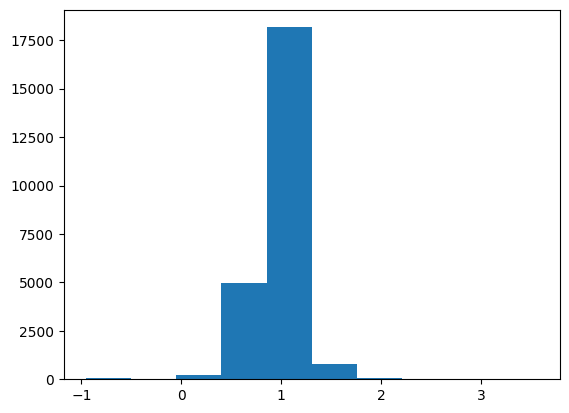

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_pred)
plt.show()

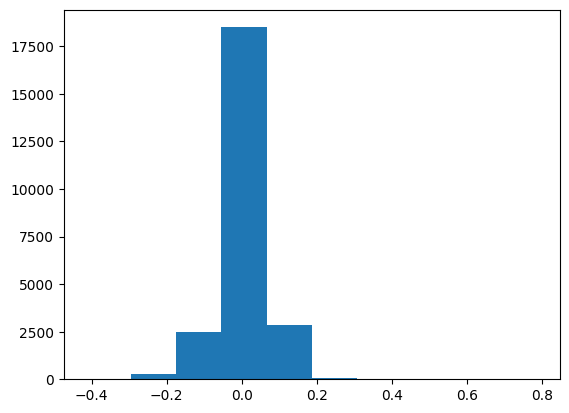

In [ ]:
plt.hist(gspc['30DaysPercent'])
plt.show()

Next, let's look at the Thrift Savings Plan's C Fund, which is supposed to follow the S&P 500 to see if the strategy is effective for ETF investiture.

In [ ]:
#cfund.head()

In [ ]:
#cfund.describe()

In [ ]:
## Sentiment, sentiment_data.csv in shared file is utilized
## 576 days without sentiment score between 2009-07-27 & 2020-06-11
## sentiment_df only has aggregated score daily, sentiment_percentages has daily headline percentage
## negative:0, neutral:1, positive:2

import pandas as pd

sent_path =  "/content/drive/My Drive/DAT490 Working Folder/Main model working folder/sentiment_data.csv"

sentiment = pd.read_csv(sent_path, parse_dates=["Date"])
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.tz_localize(None).dt.normalize()
sentiment_df = sentiment[['Date','sentiment_encoded']]

sentiment_counts = sentiment.groupby(['Date', 'sentiment_encoded']).size().unstack(fill_value=0)
sentiment_counts['total'] = sentiment_counts.sum(axis=1)
sentiment_percentages = sentiment_counts.div(sentiment_counts['total'], axis=0)


sentiment_df = sentiment.groupby("Date")[["sentiment_encoded"]].mean().reset_index()
sentiment_df = sentiment_df.sort_values("Date")

In [ ]:
sentiment_df["Date"].min(), sentiment_df["Date"].max()

(Timestamp('2009-07-27 00:00:00'), Timestamp('2020-06-11 00:00:00'))

In [ ]:
sentiment_df.describe()

,Date,sentiment_encoded
count,3396,3396.00
mean,2015-05-26 20:56:23.745583104,1.43
min,2009-07-27 00:00:00,0.00
25%,2012-10-14 12:00:00,1.21
50%,2015-07-12 12:00:00,1.43
75%,2018-02-03 06:00:00,1.70
max,2020-06-11 00:00:00,2.00
std,NaN,0.40


In [ ]:
gspc['Date'].describe()

,Date
count,24313
mean,1976-08-10 18:19:30.040718976
min,1928-02-17 00:00:00
25%,1952-06-19 00:00:00
50%,1976-09-14 00:00:00
75%,2000-10-02 00:00:00
max,2024-11-29 00:00:00


In [ ]:
sentiment_df['sentiment_encoded'] = sentiment_df['sentiment_encoded'].fillna(method='ffill')

<ipython-input-70-5bd3017c3b02>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_df['sentiment_encoded'] = sentiment_df['sentiment_encoded'].fillna(method='ffill')


In [ ]:
# macroeconomic trends (CPI, etc.)
!pip install fredapi

from fredapi import Fred
fred = Fred(api_key='dab4815a04eb85f8ef19813a52a64180')

# Retrieve data
cpi = fred.get_series('CPIAUCSL')               # Consumer Price Index
unemployment = fred.get_series('UNEMPLOY')      # Unemployment Rate
interest_rate = fred.get_series('FEDFUNDS')     # Federal Funds Rate
oil_price = fred.get_series('DCOILWTICO')       # West Texas Intermediate Crude
egg_price = fred.get_series('APU0000708111')    # Average price: eggs
unemployment_rate = fred.get_series('UNRATE')   # U.S. Unemployment Rate
gdp_growth = fred.get_series('A191RL1Q225SBEA') # Real GDP (percent change)
treasury_yield_10y = fred.get_series('DGS10')   # Treasury Yield (10-Year)
gold_price = fred.get_series('IR14270')         # Gold Price (Daily from IMF)
usd_index = fred.get_series('DTWEXBGS')         # U.S. Dollar Index (Nominal Broad)



# Combine into a DataFrame
macroindicators_df = pd.DataFrame({
    'CPI': cpi,
    'Unemployment Rate': unemployment,
    'Federal Funds Rate': interest_rate,
    'Oil Price': oil_price,
    'Egg Price': egg_price,
    'Unemployment Rate': unemployment_rate,
    'Real GDP Growth': gdp_growth,
    'Treasury Yield (10-Year)': treasury_yield_10y,
    'Gold Price': gold_price,
    'U.S. Dollar Index': usd_index

})

# Display the first few rows
print(macroindicators_df.head())

             CPI  Unemployment Rate  Federal Funds Rate  Oil Price  Egg Price  \
1947-01-01 21.48                NaN                 NaN        NaN        NaN   
1947-02-01 21.62                NaN                 NaN        NaN        NaN   
1947-03-01 22.00                NaN                 NaN        NaN        NaN   
1947-04-01 22.00                NaN                 NaN        NaN        NaN   
1947-05-01 21.95                NaN                 NaN        NaN        NaN   

            Real GDP Growth  Treasury Yield (10-Year)  Gold Price  \
1947-01-01              NaN                       NaN         NaN   
1947-02-01              NaN                       NaN         NaN   
1947-03-01              NaN                       NaN         NaN   
1947-04-01            -1.00                       NaN         NaN   
1947-05-01              NaN                       NaN         NaN   

            U.S. Dollar Index  
1947-01-01                NaN  
1947-02-01                NaN  
19

In [ ]:
macroindicators_df.head()

,CPI,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index
1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-02-01,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,22.00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN,NaN
1947-05-01,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
macroindicators_df = macroindicators_df.reset_index()
macroindicators_df = macroindicators_df.rename(columns={'index':'Date'})

In [ ]:
#gspc['Date'] = pd.to_datetime(gspc['Date']).dt.tz_localize(None).dt.normalize()

In [ ]:
gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
0,1928-02-17,17.04,17.04,17.04,17.04,0.00,17.04,17.44,17.50,17.21,...,0,0,0,0,0,0,0,0,0,0
1,1928-02-20,16.95,16.95,16.95,16.95,0.00,16.95,17.39,17.47,17.10,...,0,0,0,0,0,0,0,0,0,1
2,1928-02-21,17.11,17.11,17.11,17.11,0.00,17.11,17.37,17.45,17.05,...,0,0,0,0,0,0,0,0,0,0
3,1928-02-23,17.13,17.13,17.13,17.13,0.00,17.13,17.34,17.42,17.02,...,0,0,0,0,0,0,0,0,0,0
4,1928-02-24,17.18,17.18,17.18,17.18,0.00,17.18,17.33,17.40,16.99,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df = pd.merge(gspc, sentiment_df,how='inner' , on='Date')

In [ ]:
merged_df.describe()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
count,2658,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,...,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00,2658.00
mean,2015-02-22 19:32:22.212189696,1992.42,2002.43,1981.55,1992.83,3813343788.56,1992.83,1985.73,1985.61,1928.34,...,0.02,0.06,0.07,0.08,0.01,0.00,0.02,0.01,0.07,1.38
min,2009-07-27 00:00:00,978.63,982.49,972.29,979.73,1030000000.00,979.73,937.58,925.28,858.69,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2012-06-26 06:00:00,1378.73,1388.91,1371.25,1379.45,3267397500.00,1379.45,1381.72,1380.20,1341.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.19
50%,2015-03-03 12:00:00,2003.86,2018.29,1992.90,2002.47,3640845000.00,2002.47,1993.76,1996.30,1948.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.38
75%,2017-10-18 18:00:00,2502.21,2520.08,2492.31,2506.80,4146312500.00,2506.80,2536.87,2521.75,2420.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.57
max,2020-06-11 00:00:00,3380.45,3393.52,3378.83,3386.15,10617810000.00,3386.15,3334.70,3323.17,3231.29,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
std,NaN,622.28,624.37,619.73,622.06,940291768.33,622.06,619.45,619.75,602.84,...,0.14,0.24,0.25,0.27,0.08,0.03,0.12,0.09,0.26,0.33


In [ ]:
merged_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
0,2009-07-27,978.63,982.49,972.29,982.18,4631290000.00,982.18,937.58,925.28,858.69,...,0,0,0,1,0,0,0,0,0,2.00
1,2009-08-07,999.83,1018.00,999.83,1010.48,6827090000.00,1010.48,972.70,968.29,905.77,...,0,0,0,1,0,0,0,0,1,2.00
2,2009-08-10,1008.89,1010.12,1000.99,1007.10,5406080000.00,1007.10,975.98,973.59,917.08,...,0,0,0,1,0,0,0,0,0,1.00
3,2009-08-12,994.00,1012.78,993.36,1005.81,5498170000.00,1005.81,980.40,981.67,937.25,...,0,0,0,0,0,0,0,0,0,2.00
4,2009-08-13,1005.86,1013.14,1000.82,1012.73,5250660000.00,1012.73,983.48,985.27,943.09,...,0,0,0,0,0,0,0,0,0,1.00


***Training set - pre-2004***

In [ ]:
gspc['Date'].iloc[19000:]

,Date
19000,2003-10-22
19001,2003-10-23
19002,2003-10-24
19003,2003-10-27
19004,2003-10-28
...,...
24308,2024-11-22
24309,2024-11-25
24310,2024-11-26
24311,2024-11-27


In [ ]:
training_gspc = gspc[0:19000].copy()
testing_gspc = gspc[19000:].copy()

In [ ]:
X = training_gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y = training_gspc['nDaysDown']
yup = training_gspc['nDaysUp']
X2 = testing_gspc[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','2dayMomentum']]
y2 = testing_gspc['nDaysDown']
y2up = testing_gspc['nDaysUp']
#
X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X2 = pd.DataFrame(X2)
y2 = pd.DataFrame(y2)
y2up = pd.DataFrame(y2up)
#

classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)

In [ ]:
testing_gspc.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_buy,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy
19000,2003-10-22,1046.03,1046.03,1028.39,1030.36,1647200000.00,1030.36,1034.46,1030.36,996.10,...,0,0,0,1,0,0,0,0,0,1
19001,2003-10-23,1030.36,1035.44,1025.89,1033.77,1604300000.00,1033.77,1034.39,1031.88,999.94,...,0,0,0,0,0,0,0,0,0,0
19002,2003-10-24,1033.77,1033.77,1018.32,1028.91,1420300000.00,1028.91,1033.87,1033.49,1005.81,...,0,0,0,0,0,0,0,0,0,0
19003,2003-10-27,1028.91,1037.75,1028.91,1031.13,1371800000.00,1031.13,1033.61,1034.72,1009.89,...,0,0,0,0,0,0,0,0,0,0
19004,2003-10-28,1031.13,1046.79,1031.13,1046.79,1629200000.00,1046.79,1034.87,1037.26,1019.38,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
testing_gspc.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy'],
      dtype='object')

In [ ]:
testing_sell = classifier.predict(X2)
testing_buy = classifier2.predict(X2)

In [ ]:
testing_gspc['buy'] = testing_buy
testing_gspc['sell'] = testing_sell

In [ ]:
cm = confusion_matrix(y2, testing_sell)
print(cm)

[[3285 1271]
 [ 579  178]]


In [ ]:
cm = confusion_matrix(y2, testing_buy)
print(cm)

[[4384  172]
 [ 708   49]]


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (testing_gspc['buy'].iloc[i] ==1) and (testing_gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/testing_gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (testing_gspc['sell'].iloc[i] == 1) and (testing_gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*testing_gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*testing_gspc['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      28473
Stock Value:       7.57
102230.36


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/testing_gspc['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:     355128
Stock Value:      58.87
102230.36


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier.fit(X, np.ravel(y,order='C'))
classifier2.fit(X, np.ravel(yup,order='C'))
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)

In [ ]:
testing_sell = classifier.predict(X2)
testing_buy = classifier2.predict(X2)

In [ ]:
testing_gspc['buy'] = testing_buy
testing_gspc['sell'] = testing_sell

In [ ]:
cm = confusion_matrix(y2, testing_sell)
print(cm)

[[4227  329]
 [ 693   64]]


In [ ]:
cm = confusion_matrix(y2, testing_buy)
print(cm)

[[3514 1042]
 [ 570  187]]


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = testing_gspc['Date'].iloc[0].month
for i in range(len(testing_gspc)):
  month_of_record = testing_gspc['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/testing_gspc['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (testing_gspc['buy'].iloc[i] ==1) and (testing_gspc['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/testing_gspc['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (testing_gspc['sell'].iloc[i] == 1) and (testing_gspc['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*testing_gspc['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*testing_gspc['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*testing_gspc['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:     149440
Stock Value:      24.96
102230.36


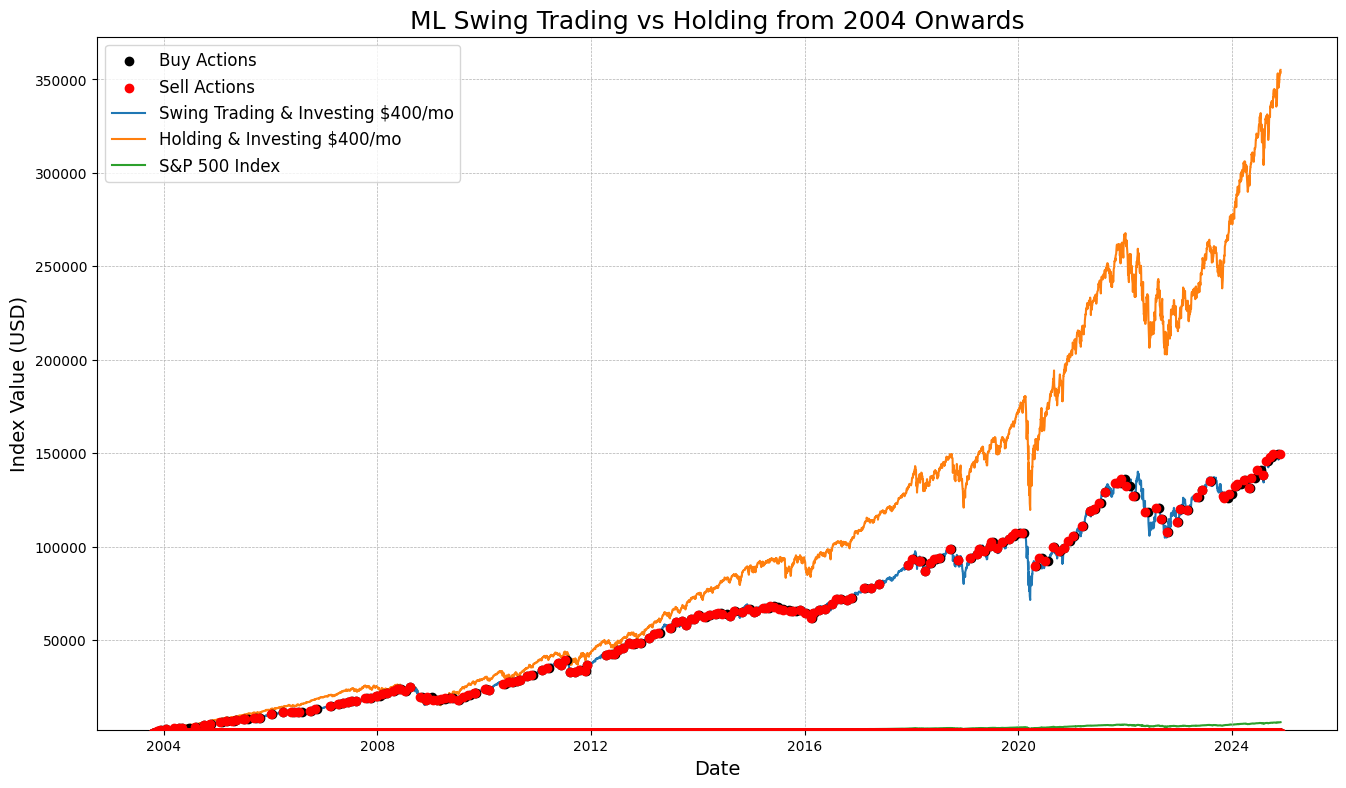

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(testing_gspc['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(testing_gspc['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(testing_gspc['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(testing_gspc['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(testing_gspc['Date'],testing_gspc['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
merged_df.isna().sum(axis=0)

,0
Date,0
GSPC.Open,0
GSPC.High,0
GSPC.Low,0
GSPC.Close,0
GSPC.Volume,0
GSPC.Adjusted,0
EMA,0
SMA,0
bb_dn,0


In [ ]:
merged_df['sentiment_encoded'] = merged_df['sentiment_encoded']-1

In [ ]:
merged_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
0,2009-07-27,978.63,982.49,972.29,982.18,4631290000.00,982.18,937.58,925.28,858.69,...,0,0,0,1,0,0,0,0,0,1.00
1,2009-08-07,999.83,1018.00,999.83,1010.48,6827090000.00,1010.48,972.70,968.29,905.77,...,0,0,0,1,0,0,0,0,1,1.00
2,2009-08-10,1008.89,1010.12,1000.99,1007.10,5406080000.00,1007.10,975.98,973.59,917.08,...,0,0,0,1,0,0,0,0,0,0.00
3,2009-08-12,994.00,1012.78,993.36,1005.81,5498170000.00,1005.81,980.40,981.67,937.25,...,0,0,0,0,0,0,0,0,0,1.00
4,2009-08-13,1005.86,1013.14,1000.82,1012.73,5250660000.00,1012.73,983.48,985.27,943.09,...,0,0,0,0,0,0,0,0,0,0.00


In [ ]:
merged_df.columns

Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy',
       'sentiment_encoded'],
      dtype='object')

In [ ]:
len(merged_df)*.8

2126.4

In [ ]:
train_df = merged_df.iloc[0:2100].copy()
test_df = merged_df.iloc[2100:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sell,buy,sentiment_encoded
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,1,0,0,0,0,0,0,0,0,0.44
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0,0,0,0,0,0,0,0,0,0.43
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0,0,0,0,0,0,0,0,0,0.38
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0,0,0,0,0,0,0,0,0,0.00
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0,0,0,0,0,0,0,0,1,0.43


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','sentiment_encoded']]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI','risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell','sentiment_encoded']]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[1864    9]
 [ 214   13]]
[[1449   19]
 [ 629    3]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[452   7]
 [ 98   1]]
[[285  50]
 [181  42]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[451   8]
 [ 98   1]]
[[292  43]
 [178  45]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,macd_sell,ema_buy,ema_sell,risingROC70RSI,fallingROC70RSI,risingROC30RSI,fallingROC30RSI,sentiment_encoded,buy,sell
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,1,0,0,0,0,0,0,0.44,0,0
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0,0,0,0,0,0,0,0.43,0,0
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0,0,0,0,0,0,0,0.38,1,0
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0,0,0,0,0,0,0,0.00,0,0
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0,0,0,0,0,0,0,0.43,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      12462
Stock Value:       4.15
13458.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      14377
Stock Value:       4.79
11830.36


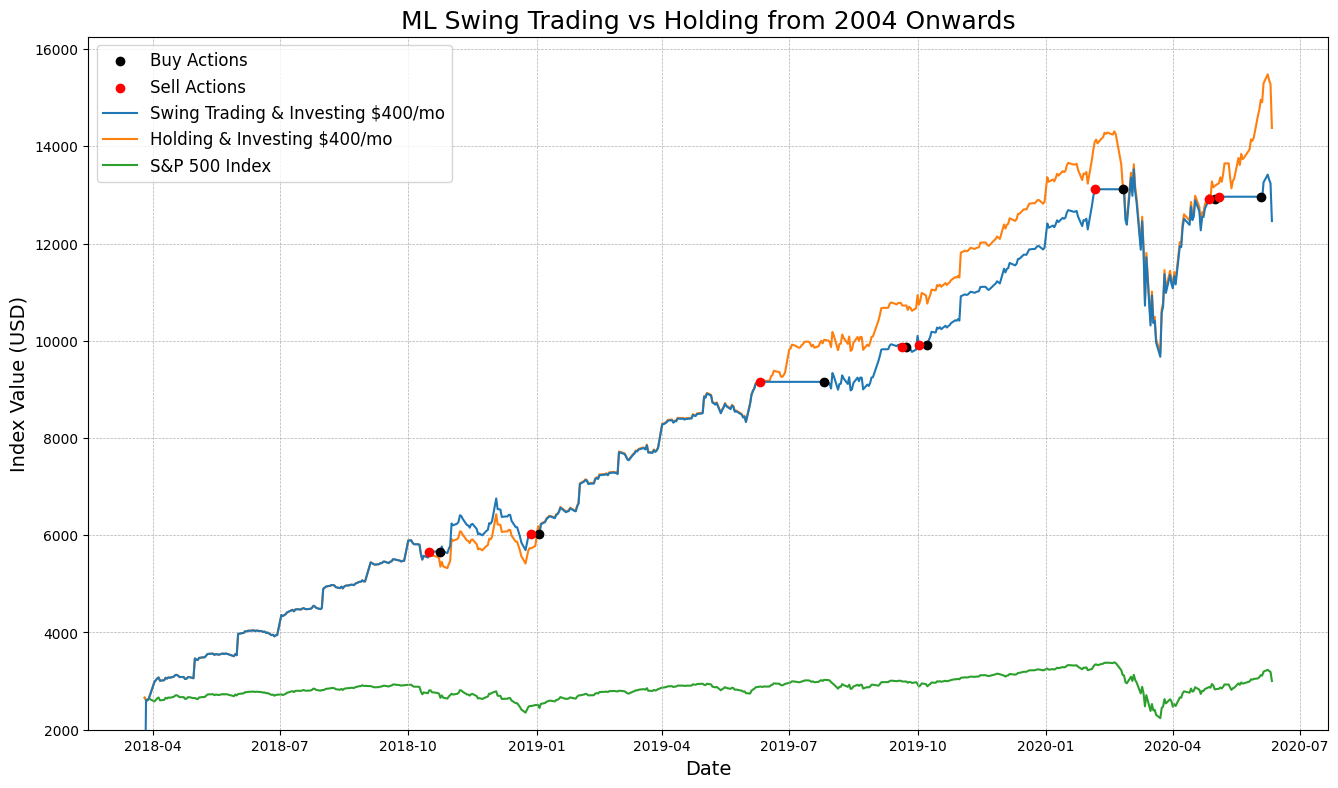

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
sentiment_percentages.head()

sentiment_encoded,0,1,2,total
Date,,,,
2009-07-27,0.00,0.00,1.00,1.00
2009-08-07,0.00,0.00,1.00,1.00
2009-08-10,0.50,0.00,0.50,1.00
2009-08-12,0.00,0.00,1.00,1.00
2009-08-13,0.50,0.00,0.50,1.00


In [ ]:
# Rename the sentiment_percentages columns
sentiment_percentages = sentiment_percentages.rename(columns={
    0: 'negative_pct',
    1: 'neutral_pct',
    2: 'positive_pct'
})

# Calculate 3-day and 7-day rolling averages
sentiment_percentages = sentiment_percentages.sort_index()
sentiment_percentages['positive_pct_3d'] = sentiment_percentages['positive_pct'].rolling(3).mean()
sentiment_percentages['neutral_pct_3d'] = sentiment_percentages['neutral_pct'].rolling(3).mean()
sentiment_percentages['negative_pct_3d'] = sentiment_percentages['negative_pct'].rolling(3).mean()

sentiment_percentages['positive_pct_7d'] = sentiment_percentages['positive_pct'].rolling(7).mean()
sentiment_percentages['neutral_pct_7d'] = sentiment_percentages['neutral_pct'].rolling(7).mean()
sentiment_percentages['negative_pct_7d'] = sentiment_percentages['negative_pct'].rolling(7).mean()

# Fill missing values
sentiment_percentages = sentiment_percentages.fillna(method='bfill').fillna(method='ffill')

# Reset index to make 'Date' a column
sentiment_percentages = sentiment_percentages.reset_index()

# Merge into merged_df
merged_df = pd.merge(merged_df, sentiment_percentages[['Date',
                                                       'positive_pct', 'neutral_pct', 'negative_pct',
                                                       'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
                                                       'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d']],
                     on='Date', how='left')


<ipython-input-114-8e9153cc7b1f>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_percentages = sentiment_percentages.fillna(method='bfill').fillna(method='ffill')


In [ ]:
train_df = merged_df.iloc[0:2100].copy()
test_df = merged_df.iloc[2100:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,sentiment_encoded,positive_pct,neutral_pct,negative_pct,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,0.44,0.63,0.19,0.19,0.71,0.12,0.17,0.66,0.18,0.17
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0.43,0.57,0.29,0.14,0.57,0.21,0.22,0.66,0.17,0.17
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0.38,0.62,0.12,0.25,0.61,0.20,0.19,0.66,0.18,0.16
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0.00,0.33,0.33,0.33,0.51,0.25,0.24,0.60,0.19,0.21
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0.43,0.62,0.19,0.19,0.87,0.06,0.06,0.68,0.16,0.16


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
              'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy',
              'macd_sell','sentiment_encoded','positive_pct', 'neutral_pct',
              'negative_pct', 'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
              'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d']]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
              'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy',
              'macd_sell','sentiment_encoded','positive_pct', 'neutral_pct',
              'negative_pct', 'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
              'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d']]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[1862   11]
 [ 202   25]]
[[1437   31]
 [ 627    5]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[450   9]
 [ 97   2]]
[[284  51]
 [186  37]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[452   7]
 [ 99   0]]
[[280  55]
 [172  51]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,neutral_pct,negative_pct,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d,buy,sell
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,0.19,0.19,0.71,0.12,0.17,0.66,0.18,0.17,0,0
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0.29,0.14,0.57,0.21,0.22,0.66,0.17,0.17,0,0
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0.12,0.25,0.61,0.20,0.19,0.66,0.18,0.16,1,0
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0.33,0.33,0.51,0.25,0.24,0.60,0.19,0.21,1,0
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0.19,0.19,0.87,0.06,0.06,0.68,0.16,0.16,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      13616
Stock Value:       4.54
13458.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      14377
Stock Value:       4.79
11830.36


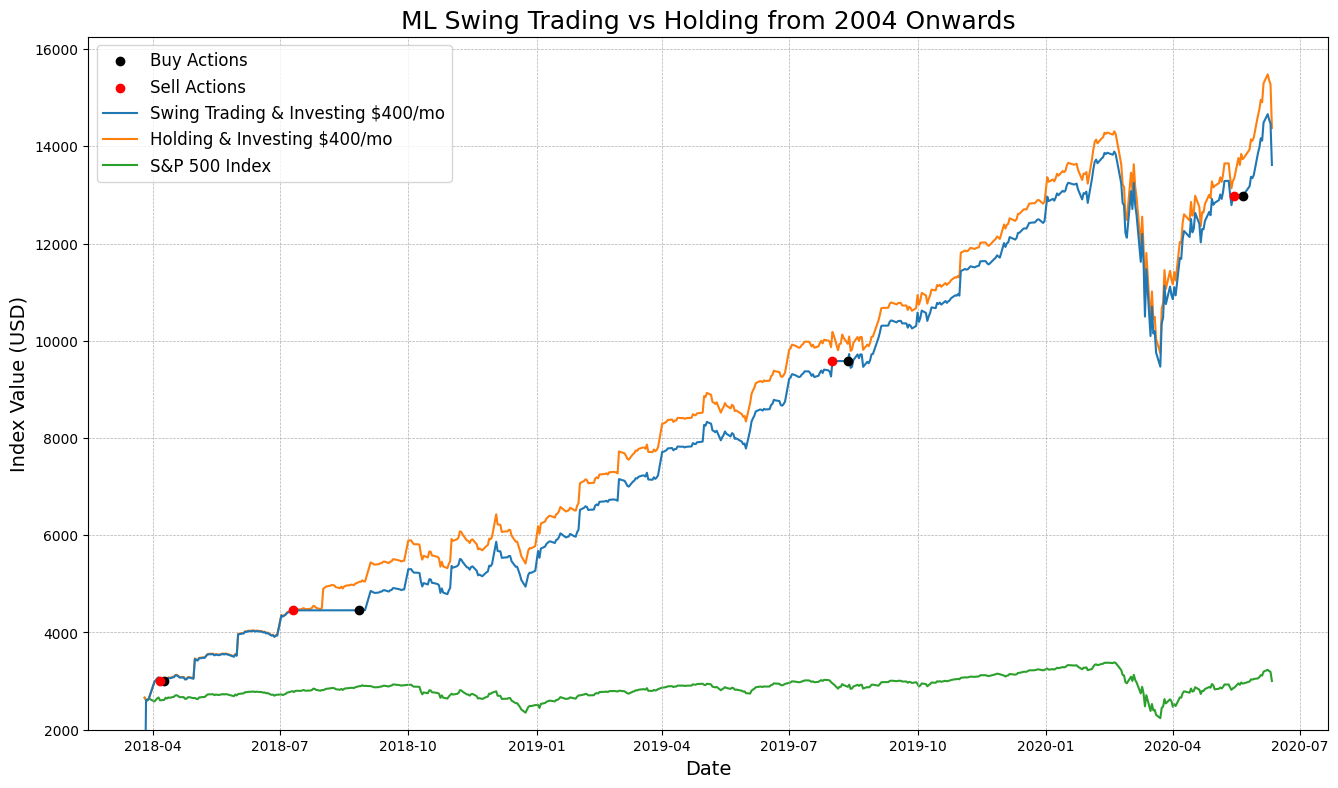

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Create new future-based columns
gspc['future_max_30'] = gspc['GSPC.Close'].shift(-1).rolling(window=30, min_periods=1).max()
gspc['future_min_30'] = gspc['GSPC.Close'].shift(-1).rolling(window=30, min_periods=1).min()

# Calculate returns relative to today's close
gspc['future_max_return'] = (gspc['future_max_30'] - gspc['GSPC.Close']) / gspc['GSPC.Close']
gspc['future_min_return'] = (gspc['future_min_30'] - gspc['GSPC.Close']) / gspc['GSPC.Close']

# Create new targets (v2 = improved logic)
gspc['nDaysUp_v2'] = (gspc['future_max_return'] > 0.035).astype(int)
gspc['nDaysDown_v2'] = (gspc['future_min_return'] < -0.035).astype(int)


In [ ]:
merged_df = pd.merge(merged_df, gspc[['Date', 'nDaysDown_v2',  'nDaysUp_v2']],
                     on='Date', how='left')

In [ ]:
train_df = merged_df.iloc[0:2100].copy()
test_df = merged_df.iloc[2100:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,neutral_pct,negative_pct,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d,nDaysDown_v2,nDaysUp_v2
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,0.19,0.19,0.71,0.12,0.17,0.66,0.18,0.17,0,1
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0.29,0.14,0.57,0.21,0.22,0.66,0.17,0.17,0,1
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0.12,0.25,0.61,0.20,0.19,0.66,0.18,0.16,0,1
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0.33,0.33,0.51,0.25,0.24,0.60,0.19,0.21,0,1
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0.19,0.19,0.87,0.06,0.06,0.68,0.16,0.16,0,1


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
              'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy',
              'macd_sell','sentiment_encoded','positive_pct', 'neutral_pct',
              'negative_pct', 'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
              'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d']]
y = train_df['nDaysDown']
yup = train_df['nDaysUp_v2']

X_test = test_df[['ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
              'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy',
              'macd_sell','sentiment_encoded','positive_pct', 'neutral_pct',
              'negative_pct', 'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
              'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d']]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp_v2']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[1862   11]
 [ 202   25]]
[[1679   31]
 [ 385    5]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[450   9]
 [ 97   2]]
[[390  15]
 [127  26]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[452   7]
 [ 99   0]]
[[383  22]
 [ 90  63]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d,nDaysDown_v2,nDaysUp_v2,buy,sell
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,0.71,0.12,0.17,0.66,0.18,0.17,0,1,0,0
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,0.57,0.21,0.22,0.66,0.17,0.17,0,1,0,0
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,0.61,0.20,0.19,0.66,0.18,0.16,0,1,1,0
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,0.51,0.25,0.24,0.60,0.19,0.21,0,1,0,0
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,0.87,0.06,0.06,0.68,0.16,0.16,0,1,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      13705
Stock Value:       4.57
13458.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      14377
Stock Value:       4.79
11830.36


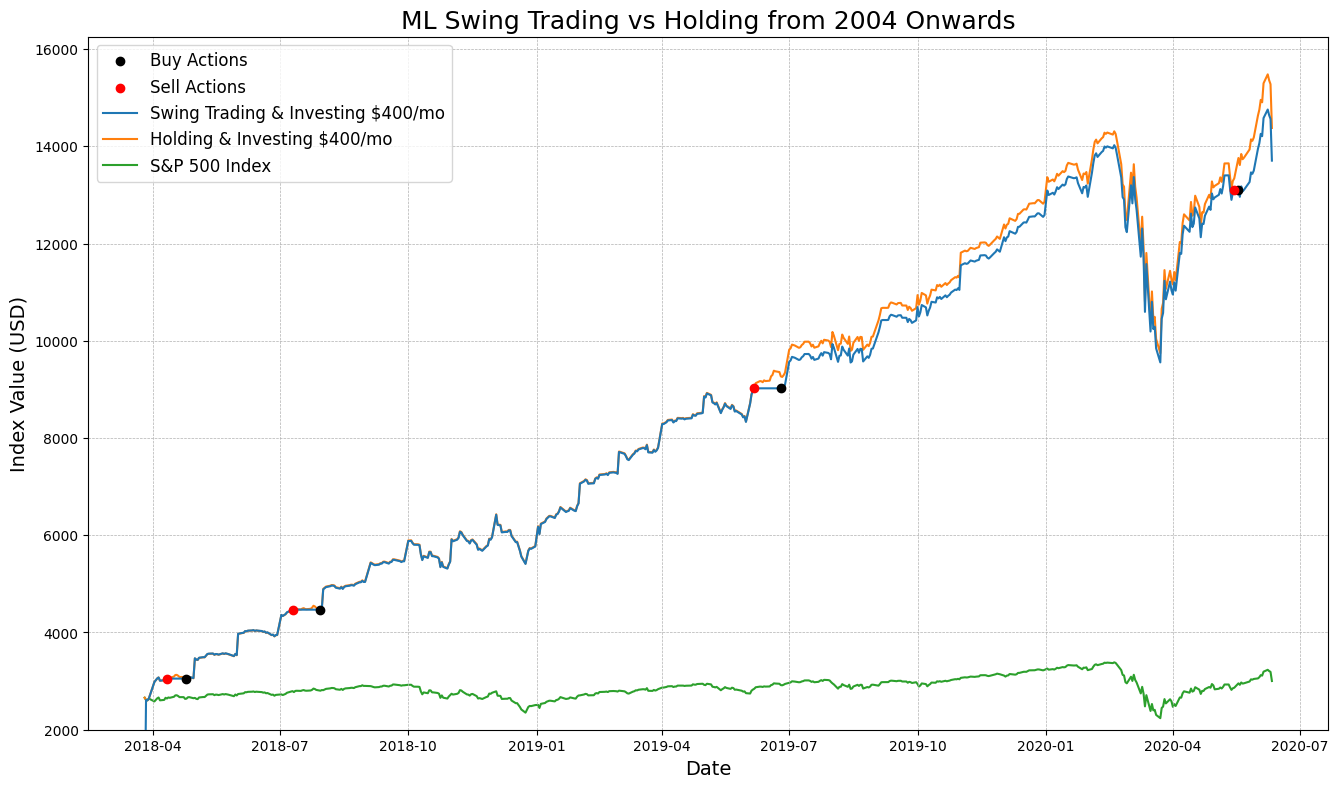

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

we are going to leave this here for now, move on to CPI with original baseline model from 2004 onwards, come back to this to see if macrotrends offer short term volatility control


In [ ]:
macroindicators_df.head()

,Date,CPI,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1947-04-01,22.00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN,NaN
4,1947-05-01,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
macroindicators_df = macroindicators_df.fillna(method='ffill')
macroindicators_df.head()

<ipython-input-140-279136462f67>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macroindicators_df = macroindicators_df.fillna(method='ffill')


,Date,CPI,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1947-04-01,22.00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN,NaN
4,1947-05-01,21.95,NaN,NaN,NaN,NaN,-1.00,NaN,NaN,NaN


In [ ]:
merged_df = pd.merge(merged_df, macroindicators_df, how='left', on='Date')
merged_df = merged_df.fillna(method='ffill')
merged_df.columns

<ipython-input-141-e50e5fe58311>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df = merged_df.fillna(method='ffill')


Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy', 'sentiment_encoded',
       'positive_pct', 'neutral_pct', 'negative_pct', 'positive_pct_3d',
       'neutral_pct_3d', 'negative_pct_3d', 'positive_pct_7d',
       'neutral_pct_7d', 'negative_pct_7d', 'nDaysDown_v2', 'nDaysUp_v2',
       'CPI', 'Unemployment Rate', 'Federal Funds Rate', 'Oil Price',
       'Egg Price', 'Real GDP Growth', 'Treasu

In [ ]:
features = [
    'ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
    'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell',
    'CPI', 'Unemployment Rate', 'Federal Funds Rate', 'Oil Price',
    'Egg Price', 'Real GDP Growth', 'Treasury Yield (10-Year)',
    'Gold Price', 'U.S. Dollar Index'
]

In [ ]:
len(merged_df) * 0.8

2126.4

In [ ]:
train_df = merged_df.iloc[0:2100].copy()
test_df = merged_df.iloc[2100:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,nDaysUp_v2,CPI,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,1,249.58,4.00,1.51,65.49,1.83,3.30,2.85,483.60,107.18
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,1,249.58,4.00,1.51,65.21,1.83,3.30,2.78,483.60,107.34
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,1,249.58,4.00,1.51,64.30,1.83,3.30,2.77,483.60,107.57
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,1,249.58,4.00,1.51,64.87,1.83,3.30,2.74,483.60,107.67
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,1,250.23,4.00,1.69,63.05,2.08,2.10,2.73,486.90,107.70


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[features]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[features]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[1845   28]
 [  55  172]]
[[1268  200]
 [ 632    0]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[453   6]
 [ 99   0]]
[[249  86]
 [129  94]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[458   1]
 [ 99   0]]
[[215 120]
 [ 88 135]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,Unemployment Rate,Federal Funds Rate,Oil Price,Egg Price,Real GDP Growth,Treasury Yield (10-Year),Gold Price,U.S. Dollar Index,buy,sell
2100,2018-03-26,2619.35,2661.36,2601.81,2658.55,3538080000.00,2658.55,2706.65,2717.89,2624.29,...,4.00,1.51,65.49,1.83,3.30,2.85,483.60,107.18,0,0
2101,2018-03-27,2667.57,2674.78,2596.12,2612.62,3761320000.00,2612.62,2697.70,2711.31,2608.04,...,4.00,1.51,65.21,1.83,3.30,2.78,483.60,107.34,0,0
2102,2018-03-28,2611.30,2632.65,2593.06,2605.00,3875720000.00,2605.00,2688.87,2705.87,2592.71,...,4.00,1.51,64.30,1.83,3.30,2.77,483.60,107.57,0,0
2103,2018-03-29,2614.41,2659.07,2609.72,2640.87,3572360000.00,2640.87,2684.30,2704.03,2587.93,...,4.00,1.51,64.87,1.83,3.30,2.74,483.60,107.67,0,0
2104,2018-04-02,2633.45,2638.30,2553.80,2581.88,3635780000.00,2581.88,2674.54,2698.56,2570.85,...,4.00,1.69,63.05,2.08,2.10,2.73,486.90,107.70,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:       8566
Stock Value:       2.85
13458.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      14377
Stock Value:       4.79
11830.36


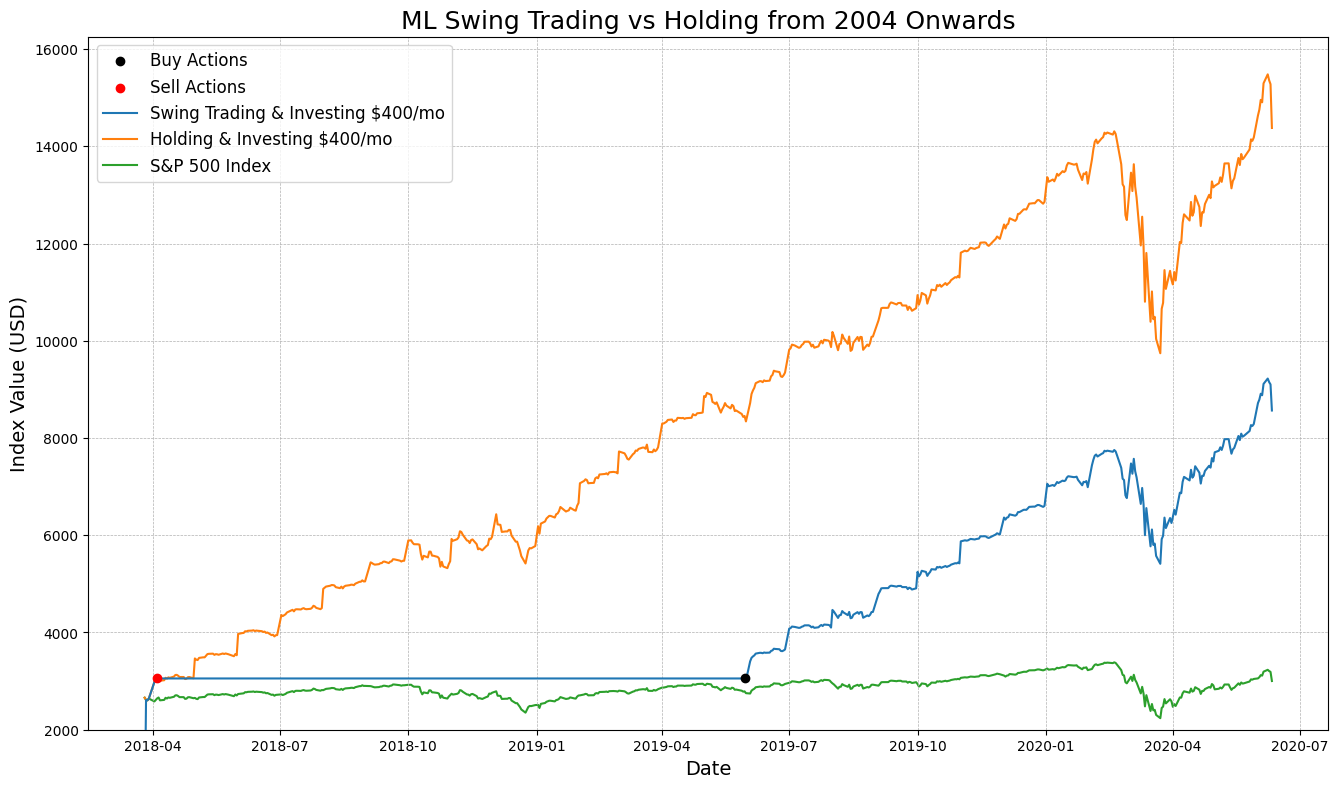

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Create macro change (%) features
macroindicators_df['CPI_change'] = macroindicators_df['CPI'].pct_change()
macroindicators_df['Unemployment_change'] = macroindicators_df['Unemployment Rate'].pct_change()
macroindicators_df['Federal_Funds_Rate_change'] = macroindicators_df['Federal Funds Rate'].pct_change()
macroindicators_df['Oil_Price_change'] = macroindicators_df['Oil Price'].pct_change()
macroindicators_df['Egg_Price_change'] = macroindicators_df['Egg Price'].pct_change()
macroindicators_df['GDP_Growth_change'] = macroindicators_df['Real GDP Growth'].pct_change()
macroindicators_df['Treasury_Yield_change'] = macroindicators_df['Treasury Yield (10-Year)'].pct_change()
macroindicators_df['Gold_Price_change'] = macroindicators_df['Gold Price'].pct_change()
macroindicators_df['USD_Index_change'] = macroindicators_df['U.S. Dollar Index'].pct_change()

# Create rolling averages (trend features)
macroindicators_df['CPI_trend'] = macroindicators_df['CPI'].rolling(window=3).mean()
macroindicators_df['Unemployment_trend'] = macroindicators_df['Unemployment Rate'].rolling(window=3).mean()
macroindicators_df['Federal_Funds_Rate_trend'] = macroindicators_df['Federal Funds Rate'].rolling(window=3).mean()
macroindicators_df['Oil_Price_trend'] = macroindicators_df['Oil Price'].rolling(window=3).mean()
macroindicators_df['Egg_Price_trend'] = macroindicators_df['Egg Price'].rolling(window=3).mean()
macroindicators_df['GDP_Growth_trend'] = macroindicators_df['Real GDP Growth'].rolling(window=3).mean()
macroindicators_df['Treasury_Yield_trend'] = macroindicators_df['Treasury Yield (10-Year)'].rolling(window=3).mean()
macroindicators_df['Gold_Price_trend'] = macroindicators_df['Gold Price'].rolling(window=3).mean()
macroindicators_df['USD_Index_trend'] = macroindicators_df['U.S. Dollar Index'].rolling(window=3).mean()

# Forward fill any missing values caused by pct_change or rolling
macroindicators_df = macroindicators_df.fillna(method='ffill')

<ipython-input-155-2c5f925d9e0d>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macroindicators_df = macroindicators_df.fillna(method='ffill')


In [ ]:
# Merge macro derivatives + trends
newmerged_df = pd.merge(gspc, macroindicators_df, on='Date', how='left')

# Final forward fill just in case
newmerged_df = newmerged_df.fillna(method='ffill')
newmerged_df.dropna(inplace=True)
newmerged_df.columns

<ipython-input-156-3a6662393345>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  newmerged_df = newmerged_df.fillna(method='ffill')


Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy', 'future_max_30',
       'future_min_30', 'future_max_return', 'future_min_return', 'nDaysUp_v2',
       'nDaysDown_v2', 'CPI', 'Unemployment Rate', 'Federal Funds Rate',
       'Oil Price', 'Egg Price', 'Real GDP Growth', 'Treasury Yield (10-Year)',
       'Gold Price', 'U.S. Dollar Index', 'CPI_change', 'Unemployment_change',
       'Federal_Fu

In [ ]:
features = [
    # Technicals
    'ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
    'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell',

    # Macro - Derivatives
    'CPI_change', 'Unemployment_change', 'Federal_Funds_Rate_change',
    'Oil_Price_change', 'Egg_Price_change', 'GDP_Growth_change',
    'Treasury_Yield_change', 'Gold_Price_change', 'USD_Index_change',

    # Macro - Trends
    'CPI_trend', 'Unemployment_trend', 'Federal_Funds_Rate_trend',
    'Oil_Price_trend', 'Egg_Price_trend', 'GDP_Growth_trend',
    'Treasury_Yield_trend', 'Gold_Price_trend', 'USD_Index_trend'
]


In [ ]:
len(newmerged_df) * 0.8

3807.2000000000003

In [ ]:
train_df = newmerged_df.iloc[0:3800].copy()
test_df = newmerged_df.iloc[3800:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,USD_Index_change,CPI_trend,Unemployment_trend,Federal_Funds_Rate_trend,Oil_Price_trend,Egg_Price_trend,GDP_Growth_trend,Treasury_Yield_trend,Gold_Price_trend,USD_Index_trend
23354,2021-02-09,3910.49,3918.35,3902.64,3911.23,4568320000.00,3911.23,3825.08,3824.66,3722.33,...,-0.00,263.57,6.20,0.08,57.70,1.60,5.60,1.19,666.00,112.02
23355,2021-02-10,3920.78,3931.50,3884.94,3909.88,4837070000.00,3909.88,3833.16,3830.10,3721.95,...,-0.00,263.57,6.20,0.08,58.33,1.60,5.60,1.17,666.00,111.81
23356,2021-02-11,3916.40,3925.99,3890.39,3916.38,4590960000.00,3916.38,3841.08,3835.42,3721.45,...,-0.00,263.57,6.20,0.08,58.42,1.60,5.60,1.16,666.00,111.64
23357,2021-02-12,3911.65,3937.23,3905.78,3934.83,4135060000.00,3934.83,3850.01,3842.39,3722.16,...,-0.00,263.57,6.20,0.08,58.80,1.60,5.60,1.17,666.00,111.54
23358,2021-02-16,3939.61,3950.43,3923.85,3932.59,5058990000.00,3932.59,3857.88,3850.60,3729.31,...,0.00,263.57,6.20,0.08,59.69,1.60,5.60,1.23,666.00,111.60


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[features]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[features]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[3165   62]
 [ 104  469]]
[[2054  528]
 [1215    3]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[738  74]
 [138   9]]
[[563  17]
 [376   3]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[621 191]
 [120  27]]
[[368 212]
 [284  95]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,Unemployment_trend,Federal_Funds_Rate_trend,Oil_Price_trend,Egg_Price_trend,GDP_Growth_trend,Treasury_Yield_trend,Gold_Price_trend,USD_Index_trend,buy,sell
23354,2021-02-09,3910.49,3918.35,3902.64,3911.23,4568320000.00,3911.23,3825.08,3824.66,3722.33,...,6.20,0.08,57.70,1.60,5.60,1.19,666.00,112.02,0,0
23355,2021-02-10,3920.78,3931.50,3884.94,3909.88,4837070000.00,3909.88,3833.16,3830.10,3721.95,...,6.20,0.08,58.33,1.60,5.60,1.17,666.00,111.81,0,0
23356,2021-02-11,3916.40,3925.99,3890.39,3916.38,4590960000.00,3916.38,3841.08,3835.42,3721.45,...,6.20,0.08,58.42,1.60,5.60,1.16,666.00,111.64,0,0
23357,2021-02-12,3911.65,3937.23,3905.78,3934.83,4135060000.00,3934.83,3850.01,3842.39,3722.16,...,6.20,0.08,58.80,1.60,5.60,1.17,666.00,111.54,0,0
23358,2021-02-16,3939.61,3950.43,3923.85,3932.59,5058990000.00,3932.59,3857.88,3850.60,3729.31,...,6.20,0.08,59.69,1.60,5.60,1.23,666.00,111.60,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      18904
Stock Value:       3.13
20658.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      30502
Stock Value:       5.06
19030.36


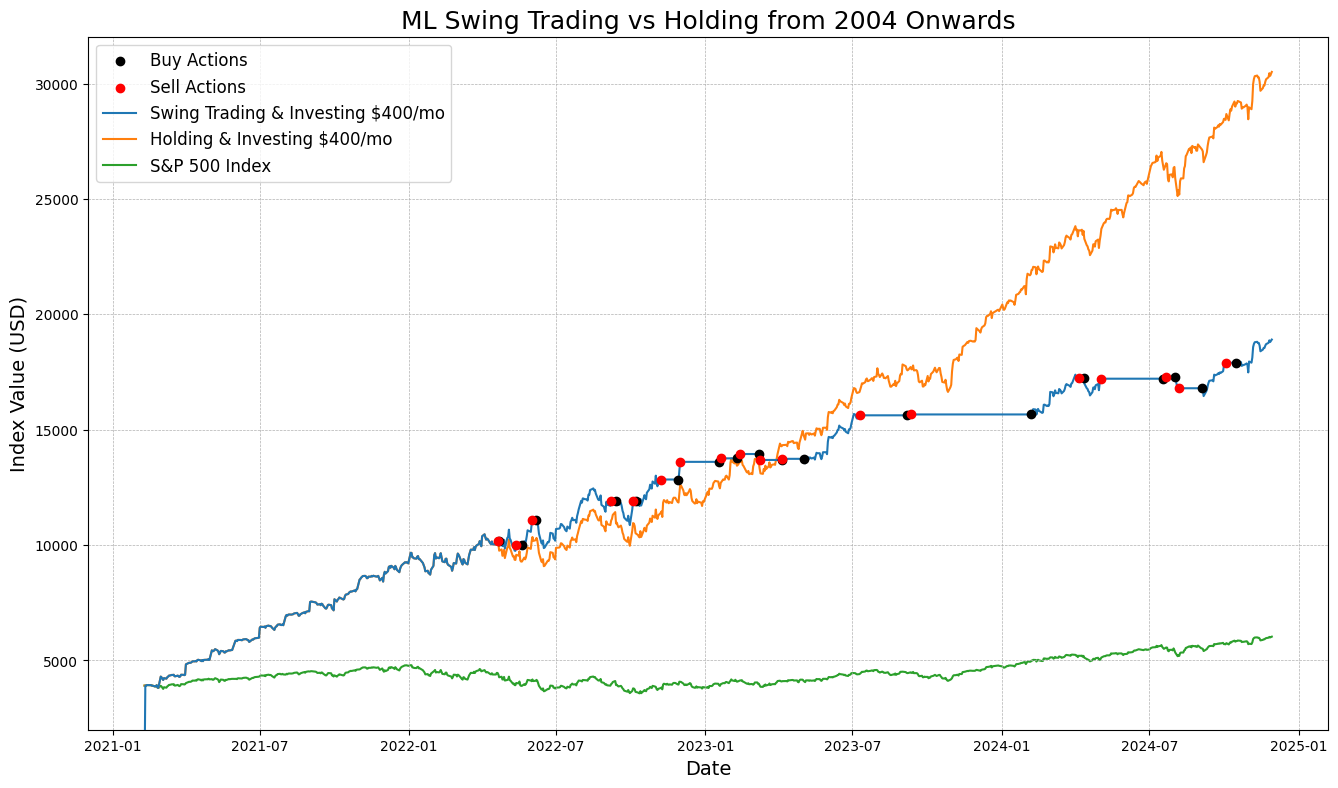

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Merge macro derivatives + trends
final_df = pd.merge(newmerged_df, sentiment_df, on='Date', how='left')

# Final forward fill just in case
final_df = final_df.fillna(method='ffill')
final_df.dropna(inplace=True)
final_df.columns

<ipython-input-170-fdb2f1abeb3b>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df = final_df.fillna(method='ffill')


Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy', 'future_max_30',
       'future_min_30', 'future_max_return', 'future_min_return', 'nDaysUp_v2',
       'nDaysDown_v2', 'CPI', 'Unemployment Rate', 'Federal Funds Rate',
       'Oil Price', 'Egg Price', 'Real GDP Growth', 'Treasury Yield (10-Year)',
       'Gold Price', 'U.S. Dollar Index', 'CPI_change', 'Unemployment_change',
       'Federal_Fu

In [ ]:
# Merge macro derivatives + trends
final_df = pd.merge(final_df, sentiment_percentages, on='Date', how='left')

# Final forward fill just in case
final_df = final_df.fillna(method='ffill')
final_df.dropna(inplace=True)
final_df.columns

<ipython-input-171-e49ba01e83fa>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df = final_df.fillna(method='ffill')


Index(['Date', 'GSPC.Open', 'GSPC.High', 'GSPC.Low', 'GSPC.Close',
       'GSPC.Volume', 'GSPC.Adjusted', 'EMA', 'SMA', 'bb_dn', 'bb_mavg',
       'bb_up', 'bb_pctB', '2dayMomentum', '2dayROC', 'macd', 'macd_signal',
       'rsi', '3DaysOutcome', '3DaysPercent', '10DaysOutcome', '10DaysPercent',
       '20DaysOutcome', '20DaysPercent', '30DaysOutcome', '30DaysPercent',
       '45DaysOutcome', '45DaysPercent', '60DaysOutcome', '60DaysPercent',
       'nDaysDown', 'nDaysUp', 'nDaysPos', 'nDaysNeg', 'macd_buy', 'macd_sell',
       'ema_buy', 'ema_sell', 'risingROC70RSI', 'fallingROC70RSI',
       'risingROC30RSI', 'fallingROC30RSI', 'sell', 'buy', 'future_max_30',
       'future_min_30', 'future_max_return', 'future_min_return', 'nDaysUp_v2',
       'nDaysDown_v2', 'CPI', 'Unemployment Rate', 'Federal Funds Rate',
       'Oil Price', 'Egg Price', 'Real GDP Growth', 'Treasury Yield (10-Year)',
       'Gold Price', 'U.S. Dollar Index', 'CPI_change', 'Unemployment_change',
       'Federal_Fu

In [ ]:
features = [
    # Technicals
    'ema_buy','ema_sell','risingROC70RSI','fallingROC70RSI',
    'risingROC30RSI','fallingROC30RSI','2dayROC','macd_buy','macd_sell',

    # Sentiment
    'sentiment_encoded',
    'positive_pct', 'neutral_pct', 'negative_pct',
    'positive_pct_3d', 'neutral_pct_3d', 'negative_pct_3d',
    'positive_pct_7d', 'neutral_pct_7d', 'negative_pct_7d',

    # Macro - Derivatives
    'CPI_change', 'Unemployment_change', 'Federal_Funds_Rate_change',
    'Oil_Price_change', 'Egg_Price_change', 'GDP_Growth_change',
    'Treasury_Yield_change', 'Gold_Price_change', 'USD_Index_change',

    # Macro - Trends
    'CPI_trend', 'Unemployment_trend', 'Federal_Funds_Rate_trend',
    'Oil_Price_trend', 'Egg_Price_trend', 'GDP_Growth_trend',
    'Treasury_Yield_trend', 'Gold_Price_trend', 'USD_Index_trend'
]


In [ ]:
len(final_df) * 0.8

3091.2000000000003

In [ ]:
train_df = final_df.iloc[0:3000].copy()
test_df = final_df.iloc[3000:].copy()
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,negative_pct,neutral_pct,positive_pct,total,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d
3000,2021-06-25,4274.45,4286.12,4271.16,4280.70,7341450000.00,4280.70,4226.58,4228.55,4177.21,...,0.10,0.45,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33
3001,2021-06-28,4284.90,4292.14,4274.67,4290.61,4147890000.00,4290.61,4232.68,4232.87,4176.20,...,0.10,0.45,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33
3002,2021-06-29,4293.21,4300.52,4287.04,4291.80,3707150000.00,4291.80,4238.31,4237.36,4177.07,...,0.10,0.45,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33
3003,2021-06-30,4290.65,4302.43,4287.96,4297.50,4266040000.00,4297.50,4243.95,4241.83,4177.74,...,0.10,0.45,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33
3004,2021-07-01,4300.73,4320.66,4300.73,4319.94,3788230000.00,4319.94,4251.19,4248.18,4179.73,...,0.10,0.45,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33


In [ ]:
train_df = train_df.drop(['sell','buy'],axis=1)
test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[features]
y = train_df['nDaysDown']
yup = train_df['nDaysUp']

X_test = test_df[features]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[2628   42]
 [  59  271]]
[[1644  313]
 [1043    0]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[717   0]
 [147   0]]
[[153 384]
 [123 204]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[700  17]
 [146   1]]
[[ 94 443]
 [ 50 277]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,positive_pct,total,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d,buy,sell
3000,2021-06-25,4274.45,4286.12,4271.16,4280.70,7341450000.00,4280.70,4226.58,4228.55,4177.21,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,1,0
3001,2021-06-28,4284.90,4292.14,4274.67,4290.61,4147890000.00,4290.61,4232.68,4232.87,4176.20,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,1,0
3002,2021-06-29,4293.21,4300.52,4287.04,4291.80,3707150000.00,4291.80,4238.31,4237.36,4177.07,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,1,0
3003,2021-06-30,4290.65,4302.43,4287.96,4297.50,4266040000.00,4297.50,4243.95,4241.83,4177.74,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,1,0
3004,2021-07-01,4300.73,4320.66,4300.73,4319.94,3788230000.00,4319.94,4251.19,4248.18,4179.73,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,1,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      28634
Stock Value:       4.75
19058.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      28133
Stock Value:       4.66
17430.36


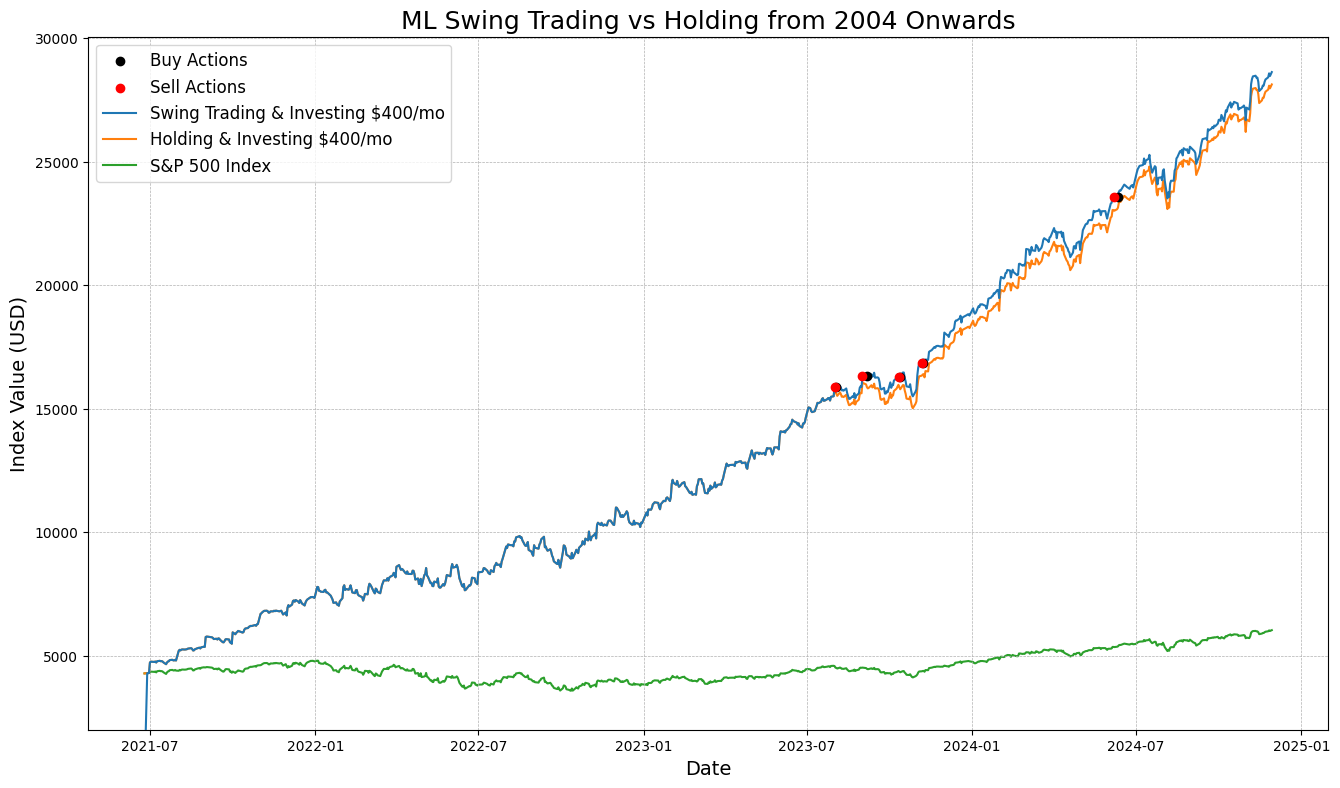

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()

In [ ]:
#train_df = train_df.drop(['sell','buy'],axis=1)
#test_df = test_df.drop(['sell','buy'],axis=1)
X = train_df[features]
y = train_df['nDaysDown']
yup = train_df['nDaysUp_v2']

X_test = test_df[features]
y_test = test_df['nDaysDown']
yup_test = test_df['nDaysUp']

X = pd.DataFrame(X)
y = pd.DataFrame(y)
yup = pd.DataFrame(yup)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
yup_test = pd.DataFrame(yup_test)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X, np.ravel(y,order='C'))
y_pred = knn.predict(X)

knn2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn2.fit(X, np.ravel(yup,order='C'))
y_pred2 = knn.predict(X)

cm = confusion_matrix(y, y_pred)
print(cm)
cm2 = confusion_matrix(yup, y_pred2)
print(cm2)

[[2628   42]
 [  59  271]]
[[2166  235]
 [ 521   78]]


In [ ]:
testing_sell = knn.predict(X_test)
testing_buy = knn2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[717   0]
 [147   0]]
[[537   0]
 [327   0]]


In [ ]:
classifier = XGBClassifier()
classifier2 = XGBClassifier()
classifier.fit(X, y) #looking for down
classifier2.fit(X, yup) #looking for up
y_pred = classifier.predict(X)
y_pred2 = classifier2.predict(X)
#
testing_sell = classifier.predict(X_test)
testing_buy = classifier2.predict(X_test)
#
cm = confusion_matrix(y_test, testing_sell)
print(cm)
cm2 = confusion_matrix(yup_test, testing_buy)
print(cm2)

[[700  17]
 [146   1]]
[[361 176]
 [228  99]]


In [ ]:
test_df['buy'] = testing_buy
test_df['sell'] = testing_sell

In [ ]:
test_df.head()

,Date,GSPC.Open,GSPC.High,GSPC.Low,GSPC.Close,GSPC.Volume,GSPC.Adjusted,EMA,SMA,bb_dn,...,positive_pct,total,positive_pct_3d,neutral_pct_3d,negative_pct_3d,positive_pct_7d,neutral_pct_7d,negative_pct_7d,buy,sell
3000,2021-06-25,4274.45,4286.12,4271.16,4280.70,7341450000.00,4280.70,4226.58,4228.55,4177.21,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,0,0
3001,2021-06-28,4284.90,4292.14,4274.67,4290.61,4147890000.00,4290.61,4232.68,4232.87,4176.20,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,0,0
3002,2021-06-29,4293.21,4300.52,4287.04,4291.80,3707150000.00,4291.80,4238.31,4237.36,4177.07,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,0,0
3003,2021-06-30,4290.65,4302.43,4287.96,4297.50,4266040000.00,4297.50,4243.95,4241.83,4177.74,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,0,0
3004,2021-07-01,4300.73,4320.66,4300.73,4319.94,3788230000.00,4319.94,4251.19,4248.18,4179.73,...,0.45,1.00,0.38,0.37,0.25,0.48,0.18,0.33,0,0


In [ ]:
import datetime
cash = 0
moneyspent = 2658.55
stock = 1
cashinhand = 0
cash_record = []
stock_record = []
buycounter = []
sellcounter = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  if (test_df['buy'].iloc[i] ==1) and (test_df['sell'].iloc[i] ==0) and cashinhand == 1 and month_trades <2:
    cash_record.append(cash)
    stock = cash/test_df['GSPC.Close'].iloc[i]
    stock_record.append(stock)
    cashinhand = 0
    cash = 0
    month_trades += 1
    buycounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    sellcounter.append(0)
  elif (test_df['sell'].iloc[i] == 1) and (test_df['buy'].iloc[i] ==0) and cashinhand == 0 and month_trades <2:
    stock_record.append(stock)
    cash = stock*test_df['GSPC.Close'].iloc[i]
    cash_record.append(cash)
    stock = 0
    cashinhand = 1
    month_trades += 1
    sellcounter.append(cash + stock*test_df['GSPC.Close'].iloc[i])
    buycounter.append(0)
  else:
    if i==0:
      cash_record.append(cash)
      stock_record.append(stock)
      buycounter.append(0)
      sellcounter.append(0)
    elif cash == 0:
      stock_record.append(stock)
      cash_record.append(stock*test_df['GSPC.Close'].iloc[i])
      buycounter.append(0)
      sellcounter.append(0)
    else:
      cash_record.append(cash_record[-1])
      stock_record.append(stock_record[-1])
      buycounter.append(0)
      sellcounter.append(0)
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record[len(cash_record)-1].astype(int))
print("Stock Value: %10.2f" % stock_record[len(stock_record)-1].astype(float))
print(moneyspent)

Cash Value:      22880
Stock Value:       3.79
19058.55


In [ ]:
import datetime
cash = 0
moneyspent = 1030.36
stock = 1
cashinhand = 0
cash_record2 = []
stock_record2 = []
month_trades = 0
curr_month = test_df['Date'].iloc[0].month
for i in range(len(test_df)):
  month_of_record = test_df['Date'].iloc[i].month
  if month_of_record != curr_month:
    curr_month = month_of_record
    month_trades = 0
    stock += 400/test_df['GSPC.Close'].iloc[i]
    moneyspent += 400
  cash_record2.append(cash + stock*test_df['GSPC.Close'].iloc[i])
  stock_record2.append(stock + cash/test_df['GSPC.Close'].iloc[i])
  i += 1
pd.options.display.float_format = '{:.2f}'.format
print("Cash Value: %10.0f" % cash_record2[len(cash_record2)-1].astype(int))
print("Stock Value: %10.2f" % stock_record2[len(stock_record2)-1].astype(float))
print(moneyspent)

Cash Value:      28133
Stock Value:       4.66
17430.36


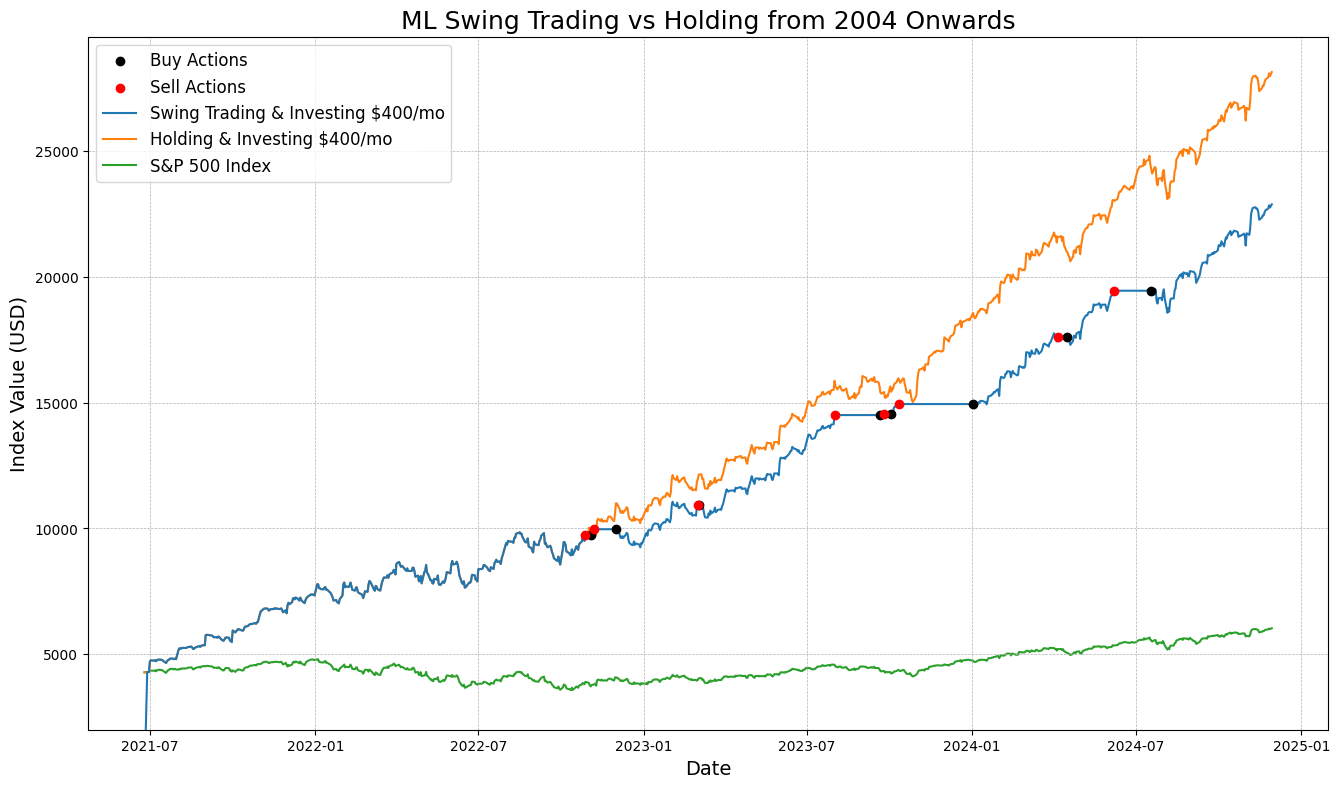

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(test_df['Date'],buycounter,color='k',label='Buy Actions',zorder=4)
plt.scatter(test_df['Date'],sellcounter,color='r',label='Sell Actions',zorder=5)
plt.plot(test_df['Date'],cash_record, label='Swing Trading & Investing $400/mo',zorder=3)
plt.plot(test_df['Date'],cash_record2, label='Holding & Investing $400/mo',zorder=2)
plt.plot(test_df['Date'],test_df['GSPC.Close'],label='S&P 500 Index',zorder=1)
ax.set_title('ML Swing Trading vs Holding from 2004 Onwards', fontsize=18)
#ax.set_yscale('log')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index Value (USD)', fontsize=14)
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_ylim(bottom=2000)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=12)
plt.show()